# E-commerce — Выявление профилей потребления

# Задача

Сегментировать покупателей по профилю потребления

- Проведите исследовательский анализ данных
- Сегментируйте покупателей на основе истории их покупок
- Сформулируйте и проверьте статистические гипотезы

## Описание проекта

Заказ от интернет-магазина товаров для дома и быта. Основной запрос от заказчика определить кто его постоянный покупатель, что покупает, в каком количстве и на какую сумму. 

Так же нужно дать рекомендации по созданию маркетинговой рассылке на основе сегментации пользователей.

Заказчик предоставил таблицу с данными: 

Колонки в  *ecommerce_dataset.csv* :

- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

## Декомпозиция задачи

* Открыть данные;

а) Загрузить необходимые библиоткеи;

б) Открыть файл с данными;

в) вывести на экран таблицу и информацию по ней;

* Изучить по формату столбцов;

а) Оценить соответсвие формата столбцов с ожидаемым форматом; 

б) Изменить формат там, где это необходимо (например date в формате int, а должно быть date);

* Изучить данные на пропуски и дубликаты;

а) Провреить таблицу на явные и неявные дубликаты;

б) Проверить данные на корректность. Если есть некорректные данные решить что с ними делать(удалить/заменить);

* Очитстить данные от выбросов, если они есть;

а) Посмотреть распрделение данных; 

б) Вывести среднее/максимальное/минимальное/медианное значения суммы заказов;

в) Построить "ящик с усами" для наглядного анализа распределения данных;

г) Убрать из таблицы пользователей у которых была слишком малая сумма заказов и заказы были единичными;

* Выделить профили потребления;

а) Выделить категории товаров;

б) Выделить кластеры пользователей, используя kmean (планирую выделять кластеры по количеству заказов);

в) Внутри каждого кластера разбить пользоватлей в зависимости от их средней суммы заказа;

г) Проверю различие среднего чека в каждом кластере, количество заказов, количество пользователей, относящихся к каждому кластеру;

а) Выделить пользователей, которые совершают заказы в опрделенный сезон;

б) Определить категории товаров, которые эти пользователи покупают;

* Проверить гипотезы: 

H0: Средний чек 0-го кластера(не более 1 покупки за все время) отличается от среднего чека 1-го кластера(более 1 покупки за все время).

H1: Средний чек 0-го кластера не отличается от Среднего чека 1-го кластера.

* Дать рекомендации по рекламной рассылке зазказчику;

а) Предложить делать рассылку клиентам по категориям товаров, которые они покупали; 

б) Предложить время(сезон) рекламную рассылку определенным кластерам клиентов;

* Сделать общие выводы. 

# Предобработка данных

Импортирую необходимые библиотеки и установлю недостающие.

In [1]:
!pip install pymystem3
!pip install openpyxl

In [2]:
import random

import pandas as pd
import matplotlib.pyplot as plt

import pprint
from pymystem3 import Mystem
from collections import Counter



from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy import stats as st
import scipy.stats as stats

import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(16, 9)})

In [3]:
import warnings
warnings.filterwarnings('ignore')

Прочитаю файл, от заказчика

In [4]:
try:
    df = pd.read_csv('/Users/andrejlesov/Downloads/ecommerce_dataset.csv')
except:
    df = pd.read_csv('ecommerce_dataset.csv')# здесь я не нашел нигде какой путь прописывать, что-бы он читался в юпитере яндекса, делаю проект локально. 
df

date                           customer_id  order_id  \
0     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4     2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
...          ...                                   ...       ...   
6732  2019103111  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73156   
6733  2019103112  1f0a7f35-7459-4f23-b468-5e45bf481dd1     73158   
6734  2019103113  25df96a7-c453-4708-9cea-a3dfc7c342ea     73162   
6735  2019103114  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73164   
6736  2019103116  344aa778-e436-419e-a9c6-9b8f37b7c1df     73137   

                                                product  quantity   price  
0       Комнатное растение в горшке Алое Вера, d12, h30         1   142.0  
1     Комнатное растение в горшке Кофе Арабика, d12,...         1   194.0  
2                           Радермахера d-12 см h-20 см         1   112.0  
3                      Хризолидокарпус Лутесценс d-9 см         1   179.0  
4                        Циперус Зумула d-12 см h-25 см         1   112.0  
...                                                 ...       ...     ...  
6732  Таз пластмассовый 40,0 л пищевой овальный (Иж)...         1   404.0  
6733         Сумка-тележка 2-х колесная Gimi Argo синяя         1  1087.0  
6734  Герань домашняя (пеларгония зональная) цветуща...         1   157.0  
6735  Таз пластмассовый со стиральной доской (Иж), 1...         1   397.0  
6736         Сумка-тележка 2-х колесная Gimi Argo синяя         1  1087.0  

[6737 rows x 6 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Пропусков и полных дубликатов нет. 

Обработка столбца с датой. 

Выделю год, месяц и дату, а так же час.

In [8]:
df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d%H')

In [9]:
df['hour'] = df['date'].dt.hour

In [10]:
firts_date = df['date'].min()
last_date = df['date'].max()
print('Минимальная дата, %s максимальная дата, %s, разница в %s.' % (firts_date, last_date, last_date - firts_date))

Минимальная дата, 2018-10-01 00:00:00 максимальная дата, 2019-10-31 16:00:00, разница в 395 days 16:00:00.


Данные за 2 года (2018 и 2019). Выделю отдельно год для возможной дальнейшей группировки. Так же выделю номер недели и номер месяца.

In [11]:
df['day_of_week'] = df['date'].dt.day_name()
df['date_day'] = df['date'].dt.date
df['week'] = df['date'].dt.week
df['month_name'] = df['date'].dt.month_name()
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6737 non-null   datetime64[ns]
 1   customer_id  6737 non-null   object        
 2   order_id     6737 non-null   int64         
 3   product      6737 non-null   object        
 4   quantity     6737 non-null   int64         
 5   price        6737 non-null   float64       
 6   hour         6737 non-null   int64         
 7   day_of_week  6737 non-null   object        
 8   date_day     6737 non-null   object        
 9   week         6737 non-null   int64         
 10  month_name   6737 non-null   object        
 11  month        6737 non-null   int64         
 12  year         6737 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 684.4+ KB


In [13]:
df.head()

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  hour  \
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0     0   
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0     0   
2                        Радермахера d-12 см h-20 см         1  112.0     0   
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0     0   
4                     Циперус Зумула d-12 см h-25 см         1  112.0     0   

  day_of_week    date_day  week month_name  month  year  
0      Monday  2018-10-01    40    October     10  2018  
1      Monday  2018-10-01    40    October     10  2018  
2      Monday  2018-10-01    40    October     10  2018  
3      Monday  2018-10-01    40    October     10  2018  
4      Monday  2018-10-01    40    October     10  2018

In [14]:
df.columns.tolist()

['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'hour',
 'day_of_week',
 'date_day',
 'week',
 'month_name',
 'month',
 'year']

Приведу все названия продуктов к строчным буквам, что бы исключить ошибки при группировках

In [15]:
df['product'] = df['product'].str.lower()

In [16]:
df1= df.loc[:,['customer_id', 'order_id']].groupby('order_id').nunique()
df1

customer_id
order_id             
12624               1
13547               1
14480               1
14481               1
14482               1
...               ...
73155               1
73156               1
73158               1
73162               1
73164               1

[2784 rows x 1 columns]

In [17]:
df1['customer_id'].unique()

array([1, 2, 3, 4])

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2784 entries, 12624 to 73164
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  2784 non-null   int64
dtypes: int64(1)
memory usage: 43.5 KB


Видно, что есть одни те же заказы, у которых почему-то несколько заказчиков. Явная ошибка данных. Так как таких ошибок немного и мы точно не знаем какой из них верный - удалю эти заказы полностью.

In [19]:
df1 = df1[(df1.customer_id <2)]
df1

customer_id
order_id             
12624               1
13547               1
14480               1
14481               1
14482               1
...               ...
73155               1
73156               1
73158               1
73162               1
73164               1

[2755 rows x 1 columns]

Получил таблицу с очищенными номерами заказов.

In [20]:
df = df1.merge(df, on='order_id', how='left')
df = df.drop(df.columns[[1]],axis = 1)
df = df.rename(columns={'customer_id_y': 'customer_id'})
df

order_id                date                           customer_id  \
0        12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
1        12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
2        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
3        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
4        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
...        ...                 ...                                   ...   
6643     73155 2019-10-31 11:00:00  f17ed857-178e-45e1-a662-0a9dd3b58c5f   
6644     73156 2019-10-31 11:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58   
6645     73158 2019-10-31 12:00:00  1f0a7f35-7459-4f23-b468-5e45bf481dd1   
6646     73162 2019-10-31 13:00:00  25df96a7-c453-4708-9cea-a3dfc7c342ea   
6647     73164 2019-10-31 14:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58   

                                                product  quantity   price  \
0                   осина обыкновенная, высота 25-50 см         1   150.0   
1                  осина обыкновенная, высота 50-100 см         1   225.0   
2     рассада зелени для кухни лаванды в кассете по ...         1   315.0   
3     рассада зелени для кухни розмарина в кассете п...         1   207.0   
4     рассада зелени для кухни тимьяна в кассете по ...         1   162.0   
...                                                 ...       ...     ...   
6643                            мимоза стыдливая d-9 см         1   329.0   
6644  таз пластмассовый 40,0 л пищевой овальный (иж)...         1   404.0   
6645         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   
6646  герань домашняя (пеларгония зональная) цветуща...         1   157.0   
6647  таз пластмассовый со стиральной доской (иж), 1...         1   397.0   

      hour day_of_week    date_day  week month_name  month  year  
0       20      Sunday  2019-06-02    22       June      6  2019  
1       20      Sunday  2019-06-02    22       June      6  2019  
2        0      Friday  2018-10-05    40    October     10  2018  
3        0      Friday  2018-10-05    40    October     10  2018  
4        0      Friday  2018-10-05    40    October     10  2018  
...    ...         ...         ...   ...        ...    ...   ...  
6643    11    Thursday  2019-10-31    44    October     10  2019  
6644    11    Thursday  2019-10-31    44    October     10  2019  
6645    12    Thursday  2019-10-31    44    October     10  2019  
6646    13    Thursday  2019-10-31    44    October     10  2019  
6647    14    Thursday  2019-10-31    44    October     10  2019  

[6648 rows x 13 columns]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6648 entries, 0 to 6647
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_id     6648 non-null   int64         
 1   date         6648 non-null   datetime64[ns]
 2   customer_id  6648 non-null   object        
 3   product      6648 non-null   object        
 4   quantity     6648 non-null   int64         
 5   price        6648 non-null   float64       
 6   hour         6648 non-null   int64         
 7   day_of_week  6648 non-null   object        
 8   date_day     6648 non-null   object        
 9   week         6648 non-null   int64         
 10  month_name   6648 non-null   object        
 11  month        6648 non-null   int64         
 12  year         6648 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memory usage: 727.1+ KB


## Вывод:

* Загрузил необходимые библиотеки; 
* Прочитал файл;
* Проверил на пропуски и дубликаты;
* Изменил столбец с датой для работы;
* Добавил столбцы, которые могут пригодиться для группировок.

# Исследовательский анализ

Посчитаю, сколько денег принесли товары и посмотрю минимальное, максимальное, среднее и медианное значение.

In [22]:
df['product_total'] = df['quantity'] * df['price']

In [23]:
df[['quantity', 'price', 'product_total']].describe()

quantity         price  product_total
count  6648.000000   6648.000000    6648.000000
mean      2.477286    456.560921     715.644103
std      15.330856    861.650823    8406.309586
min       1.000000      9.000000       9.000000
25%       1.000000    101.000000     120.000000
50%       1.000000    135.000000     157.000000
75%       1.000000    397.000000     599.000000
max    1000.000000  14917.000000  675000.000000

Посмотрим, что продалось больше всего в штуках, а что в деньгах.

In [24]:
df[df['quantity'] == 1000]

order_id                date                           customer_id  \
5814     71743 2019-06-18 15:00:00  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6   

                                                product  quantity  price  \
5814  вантуз с деревянной ручкой d14 см красный, bur...      1000  675.0   

      hour day_of_week    date_day  week month_name  month  year  \
5814    15     Tuesday  2019-06-18    25       June      6  2019   

      product_total  
5814       675000.0

In [25]:
df[df['price'] == 14917.00]

order_id                date                           customer_id  \
6046     72139 2019-07-29 17:00:00  0d87f4ae-465a-4fac-81e6-5d629761783e   

                                                product  quantity    price  \
6046  сушилка уличная leifheit 85210 linomatic v 400...         1  14917.0   

      hour day_of_week    date_day  week month_name  month  year  \
6046    17      Monday  2019-07-29    31       July      7  2019   

      product_total  
6046        14917.0

На удивление самый ходовой товар - вантуз. Продали аж 1000 штук. Больше всего денгег принесла уличная сушилка. Хотя возможно это выбросы. Разберемся с этим дальше. 

Посчитаю, сколько в каждом месяце потратили пользователи. А так же количество уникальных пользователей и уникальных продуктов в магазине.

In [26]:
df['customer_id'].nunique()

2394

In [27]:
len(df['product'].unique().tolist())

2329

In [28]:
df['product_total'].sum()

4757602.0

In [29]:
temp = df.groupby(['month_name', 'year'])['product_total'].sum().reset_index()
temp

month_name  year  product_total
0       April  2019       379783.0
1      August  2019       197490.0
2    December  2018       383069.0
3    February  2019       342641.0
4     January  2019       262830.0
5        July  2019       276547.0
6        June  2019      1082945.0
7       March  2019       299034.0
8         May  2019       301504.0
9    November  2018       371180.0
10    October  2018       420006.0
11    October  2019       239106.0
12  September  2019       201467.0

Выведу это для наглядности в график

In [30]:
month_order = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December',
 ]

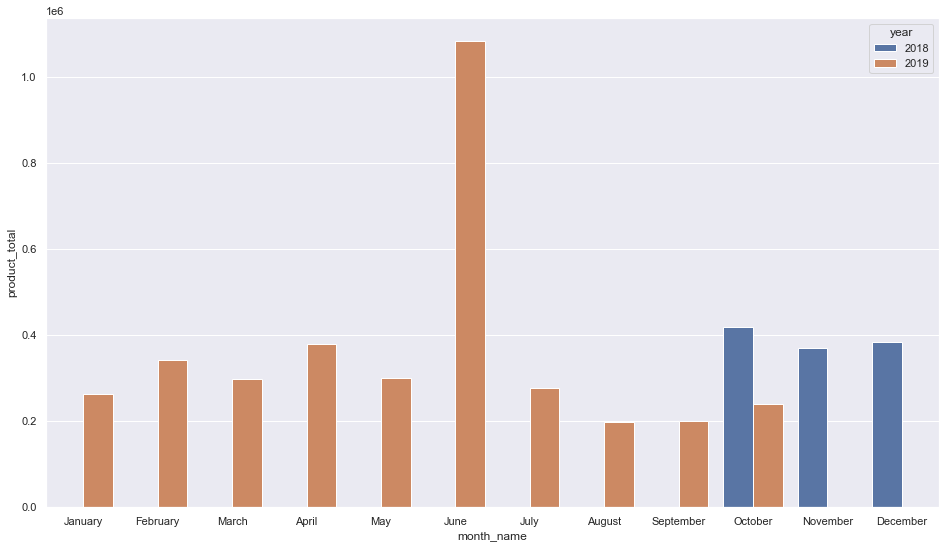

In [31]:
sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp)
plt.show()

Июнь 2019 года был очень удачным для магазина.

## Выделение категорий

Разобью товары на категории. 

In [32]:
unique_products = df['product'].unique().tolist()

In [33]:
m = Mystem()
string = '; '.join(unique_products)

In [34]:
lemmas = m.lemmatize(string)
pprint.pprint(Counter(lemmas))

Counter({' ': 15281,
         '; ': 2324,
         ', ': 1065,
         'см': 1059,
         '-': 968,
         'для': 544,
         ',': 295,
         'в': 272,
         'd': 259,
         'л': 252,
         'с': 251,
         'рассада': 221,
         '5': 189,
         ' (': 173,
         'белый': 171,
         'сорт': 171,
         'кассета': 170,
         'шт': 169,
         '0': 164,
         '12': 145,
         'красный': 143,
         'белье': 141,
         ') ': 140,
         '/': 133,
         'доска': 132,
         'горшок': 130,
         '9': 123,
         'цветок': 117,
         'сушилка': 117,
         'объем': 114,
         '2': 113,
         'гладильный': 113,
         '6': 110,
         '1': 108,
         'тележка': 107,
         'по': 101,
         '4': 101,
         'томат': 100,
         '10': 99,
         '. ': 98,
         'сумка': 97,
         'диам': 95,
         'помидор': 93,
         '*': 90,
         '№': 88,
         'пеларгония': 86,
         'розовый': 84,

         'japanese': 2,
         '19708': 2,
         'закруглять': 2,
         'короб': 2,
         'стеллажный': 2,
         'ex': 2,
         'box': 2,
         'val': 2,
         'natures': 2,
         'н': 2,
         'сальса': 2,
         'mezzaluna': 2,
         'темно-розовый': 2,
         '52': 2,
         'quadretto': 2,
         'i': 2,
         'metal': 2,
         'корыто': 2,
         'бесшовный': 2,
         '182х182': 2,
         'холодный': 2,
         'сварка': 2,
         'mastix': 2,
         '55г': 2,
         'чеснок': 2,
         'сервировочный': 2,
         '26х41': 2,
         'кружевной': 2,
         '88х38': 2,
         'city': 2,
         'step': 2,
         'lini': 2,
         '70х38': 2,
         '1290': 2,
         'ананас': 2,
         '115х35': 2,
         '45x76': 2,
         '60х91': 2,
         'серо-коричневый': 2,
         'grey': 2,
         'touch': 2,
         '1700': 2,
         'plain': 2,
         'sarasa': 2,
         'персиковый': 2,
      

         '8х1': 1,
         '5275': 1,
         '520114': 1,
         'g60': 1,
         'y': 1,
         'cr30': 1,
         'tz90': 1,
         'дампьер': 1,
         '260': 1,
         'h7939': 1,
         '1712012': 1,
         'ванная': 1,
         'bowl': 1,
         'полистирол': 1,
         '14х16': 1,
         '1014964': 1,
         'cuadro': 1,
         'mh': 1,
         'jet019': 1,
         '185х240': 1,
         'wp184': 1,
         'айленд': 1,
         'wt355': 1,
         '6194': 1,
         '6195': 1,
         '1404006': 1,
         'кумган': 1,
         '1408003': 1,
         'gp60': 1,
         'адиантум': 1,
         'лиза': 1,
         '120х180см': 1,
         'рр214': 1,
         '07034': 1,
         'дом': 1,
         'утолщенный': 1,
         'r105628': 1,
         '4302': 1,
         '301': 1,
         'livingstep': 1,
         'jean': 1,
         '107х30': 1,
         'картофель': 1,
         'proline': 1,
         '03032': 1,
         'готовый': 1,
         '

         'доминик': 1,
         '05322': 1,
         '877': 1,
         'дивали': 1,
         'd7358': 1,
         'кб': 1,
         '35х28х19': 1,
         '1524002': 1,
         'kangoo': 1,
         'powder': 1,
         'grown': 1,
         '45х125': 1,
         'сити': 1,
         '223712': 1,
         'j2132': 1,
         'пикассо': 1,
         'europa': 1,
         '21738f6ec': 1,
         '5953': 1,
         'син': 1,
         'l0886': 1,
         'шэйдс': 1,
         'h8401': 1,
         '52002': 1,
         'дл2': 1,
         'волна': 1,
         '52000': 1,
         '40x60': 1,
         'рр105': 1,
         '01001': 1,
         'ldn': 1,
         'эл': 1,
         "'": 1,
         'cadesi': 1,
         'hurrem': 1,
         '50х60': 1,
         'вырез': 1,
         '315602': 1,
         'св5': 1,
         'велад': 1,
         'l7997': 1,
         'plata': 1,
         '701003ag': 1,
         'lily': 1,
         'tracery': 1,
         'adl021': 1,
         '20920': 1,
        

         'briz': 1,
         'сн': 1,
         'ск80': 1,
         'складываться': 1,
         'parquet': 1,
         '75x45': 1,
         'amc075': 1,
         'ahm781': 1,
         'g110l04w': 1,
         'пахира': 1,
         'акватик': 1,
         'мультисть': 1,
         '1410': 1,
         'пуховый': 1,
         'пух': 1,
         '4607101064199': 1,
         'ампельнвя': 1,
         'pollicino': 1,
         '73x32': 1,
         '1404088': 1,
         'сатиновый': 1,
         'полутороспальный': 1,
         'rpe150': 1,
         'дримс': 1,
         '150х214': 1,
         'влажный': 1,
         'сухой': 1,
         '40002': 1,
         'st460': 1,
         'традесканция': 1,
         'фанк': 1,
         'лк': 1,
         'f': 1,
         'lk': 1,
         '40х40': 1,
         'wr44t': 1,
         'mnb012': 1,
         'березка': 1,
         '8040': 1,
         '707': 1,
         'xxl': 1,
         'графитовый': 1,
         '686': 1,
         'st797': 1,
         'гранит': 1,
    

In [35]:
df['word_count'] = df['product'].apply(lambda x: len(x.split()))

In [36]:
df.describe()

order_id     quantity         price         hour         week  \
count   6648.000000  6648.000000   6648.000000  6648.000000  6648.000000   
mean   42834.544224     2.477286    456.560921    13.859356    26.055656   
std    27900.119808    15.330856    861.650823     4.955792    13.155019   
min    12624.000000     1.000000      9.000000     0.000000     1.000000   
25%    14822.000000     1.000000    101.000000    10.000000    17.000000   
50%    68477.000000     1.000000    135.000000    14.000000    23.000000   
75%    70464.000000     1.000000    397.000000    18.000000    39.000000   
max    73164.000000  1000.000000  14917.000000    23.000000    52.000000   

             month         year  product_total   word_count  
count  6648.000000  6648.000000    6648.000000  6648.000000  
mean      6.415764  2018.788658     715.644103     7.986161  
std       3.028346     0.408291    8406.309586     2.317337  
min       1.000000  2018.000000       9.000000     3.000000  
25%       4.000000  2019.000000     120.000000     6.000000  
50%       6.000000  2019.000000     157.000000     8.000000  
75%       9.000000  2019.000000     599.000000     9.000000  
max      12.000000  2019.000000  675000.000000    22.000000

Минимальная длина 3 словоформы.

In [37]:
df[df['word_count'] == 3].sample(5)

order_id                date                           customer_id  \
4705     70030 2019-01-30 15:00:00  560083b4-f5a2-4a86-99c3-59e736915f42   
6114     72256 2019-08-11 20:00:00  e9e84a33-7944-4eef-b7d5-a3b11138aefc   
6419     72800 2019-09-29 18:00:00  1f2aff94-ac51-478d-bb4e-f678d08eb182   
522      14597 2019-03-28 16:00:00  e58284ef-20d2-42dd-879d-fdd6bd653f3f   
6621     73115 2019-10-28 13:00:00  5ec5d242-5b4e-4d82-9e79-86a467c0bacd   

                         product  quantity  price  hour day_of_week  \
4705          хлорофитум d-13 см         4  112.0    15   Wednesday   
6114          спатифиллум d-7 см         4   29.0    20      Sunday   
6419          хлорофитум d-13 см         1  112.0    18      Sunday   
522   вербейник монетчатый желты         1   89.0    16    Thursday   
6621                 лавр d-9 см         1   74.0    13      Monday   

        date_day  week month_name  month  year  product_total  word_count  
4705  2019-01-30     5    January      1  2019          448.0           3  
6114  2019-08-11    32     August      8  2019          116.0           3  
6419  2019-09-29    39  September      9  2019          112.0           3  
522   2019-03-28    13      March      3  2019           89.0           3  
6621  2019-10-28    44    October     10  2019           74.0           3

In [38]:
df['product_2_first_words'] = df['product'].apply(lambda x: x.split()[:2])

In [39]:
df[['product_2_first_words']].sample(5)

product_2_first_words
4086     [герань, домашняя]
5700   [таз, пластмассовый]
6162  [махровое, полотенце]
3901       [муляж, морковь]
6248   [сумка-тележка, 2-х]

Заменю симовлы )( ё ,

In [40]:
x = df.iloc[0,12]

In [41]:
df['product_2_first_words'] = df['product_2_first_words'].apply(lambda x: ' '.join(x))

In [42]:
df['product_2_first_words'] = df['product_2_first_words'].astype(str).str.replace('(', '', regex = True)
df['product_2_first_words'] = df['product_2_first_words'].astype(str).str.replace(')', '', regex = True)
df['product_2_first_words'] = df['product_2_first_words'].astype(str).str.replace(',', '', regex = True)
df['product_2_first_words'] = df['product_2_first_words'].astype(str).str.replace('ё', 'е', regex = True)

In [43]:
df['product_2_first_words'].sample(5)

3469       стяжка оконная
2874     астра альпийская
3745        подкладка под
6408    коврик придверный
3408     коврик хлопковый
Name: product_2_first_words, dtype: object

In [44]:
unique_products = df['product_2_first_words'].unique().tolist()

In [45]:
string = '; '.join(unique_products)

In [46]:
lemmas = m.lemmatize(string)
pprint.pprint(Counter(lemmas))

Counter({' ': 903,
         '; ': 903,
         '-': 80,
         'для': 68,
         'd': 38,
         'рассада': 33,
         'муляж': 30,
         'скатерть': 23,
         'петуния': 21,
         'набор': 21,
         'вешалка': 20,
         'стремянка': 17,
         'с': 16,
         'в': 15,
         'коврик': 13,
         'алюминиевый': 12,
         'пеларгония': 11,
         'махровый': 11,
         'микс': 11,
         '9': 10,
         '12': 10,
         'дыня': 9,
         'сумка': 9,
         'тележка': 9,
         'щетка': 9,
         'салатник': 9,
         'огурец': 8,
         'роза': 8,
         'пластмассовый': 8,
         'нож': 8,
         'ампельный': 7,
         'капуста': 7,
         'вербена': 7,
         'фуксия': 7,
         'кухонный': 7,
         'ведро': 7,
         'насадка': 7,
         'кружок': 7,
         'хризантема': 6,
         'косметь': 6,
         'калибрахоа': 6,
         'томат': 6,
         'цикламен': 6,
         'арбуз': 6,
         'сушилка'

         'орхидный': 1,
         'подвесной': 1,
         'кашпо': 1,
         'девичий': 1,
         'клубневой': 1,
         'orange': 1,
         'sanguna': 1,
         'регатт': 1,
         'pegasus': 1,
         'surprise': 1,
         'пиретрум': 1,
         'робинсон': 1,
         'агератум': 1,
         'колеус': 1,
         'тагетис': 1,
         'цинерания': 1,
         'potunia': 1,
         'портулак': 1,
         'аргирантерум': 1,
         'левка': 1,
         'свитуния': 1,
         'baby': 1,
         'bordeaux': 1,
         'crazytunia': 1,
         'sky': 1,
         'вероника': 1,
         'колосковый': 1,
         'целозия': 1,
         'гребенчатый': 1,
         'белокочанный': 1,
         'огонек': 1,
         'сибирский': 1,
         'холодок': 1,
         'шуга': 1,
         'самурай': 1,
         'алтайский': 1,
         'дина': 1,
         'колхозница': 1,
         'медовый': 1,
         'награда': 1,
         'альба': 1,
         'мара': 1,
         'хоня': 1

In [47]:
len(lemmas)

3778

In [48]:
df['product_first_word'] = df['product'].apply(lambda x: x.split()[:1]).apply(lambda x: ' '.join(x))

In [49]:
df.head()

order_id                date                           customer_id  \
0     12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
1     12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
2     13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
3     13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
4     13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   

                                             product  quantity  price  hour  \
0                осина обыкновенная, высота 25-50 см         1  150.0    20   
1               осина обыкновенная, высота 50-100 см         1  225.0    20   
2  рассада зелени для кухни лаванды в кассете по ...         1  315.0     0   
3  рассада зелени для кухни розмарина в кассете п...         1  207.0     0   
4  рассада зелени для кухни тимьяна в кассете по ...         1  162.0     0   

  day_of_week    date_day  week month_name  month  year  product_total  \
0      Sunday  2019-06-02    22       June      6  2019          150.0   
1      Sunday  2019-06-02    22       June      6  2019          225.0   
2      Friday  2018-10-05    40    October     10  2018          315.0   
3      Friday  2018-10-05    40    October     10  2018          207.0   
4      Friday  2018-10-05    40    October     10  2018          162.0   

   word_count product_2_first_words product_first_word  
0           5    осина обыкновенная              осина  
1           5    осина обыкновенная              осина  
2          10        рассада зелени            рассада  
3          10        рассада зелени            рассада  
4          10        рассада зелени            рассада

In [50]:
category_list = df['product_first_word'].unique().tolist()
df['product_first_word'].unique()

array(['осина', 'рассада', 'многолетнее', 'пеларгония', 'кориандр',
       'бегония', 'хризантема', 'бархатцы', 'космея', 'морковь',
       'настурция', 'огурец', 'петуния', 'алиссум', 'гвоздика', 'годеция',
       'календула', 'капуста', 'кореопсис', 'лапчатка', 'львиный',
       'флокс', 'цинерария', 'эшшольция', 'ель', 'кипарисовик', 'примула',
       'калибрахоа', 'роза', 'пуансеттия', 'цикламен', 'аквилегия',
       'базилик', 'горох', 'земляника', 'незабудка', 'седум', 'тимьян',
       'томат', 'укроп', 'декабрист', 'вербена', 'однолетнее', 'бакопа',
       'газания', 'овсянница', 'георгина', 'смолевка', 'цинния',
       'лаванда', 'лавр', 'мята', 'вербейник', 'виола', 'колокольчик',
       'котовник', 'эхинацея', 'ясколка', 'лилейник', 'папоротник',
       'платикодон', 'энотера', 'фуксия', 'гортензия', 'дыня', 'циния',
       'томата', 'бальзамин', 'лобелия', 'подвесное', 'табак', 'девичий',
       'пиретрум', 'агератум', 'колеус', 'тагетис', 'цинерания',
       'портулак', 'ас

In [51]:
category_list

['осина',
 'рассада',
 'многолетнее',
 'пеларгония',
 'кориандр',
 'бегония',
 'хризантема',
 'бархатцы',
 'космея',
 'морковь',
 'настурция',
 'огурец',
 'петуния',
 'алиссум',
 'гвоздика',
 'годеция',
 'календула',
 'капуста',
 'кореопсис',
 'лапчатка',
 'львиный',
 'флокс',
 'цинерария',
 'эшшольция',
 'ель',
 'кипарисовик',
 'примула',
 'калибрахоа',
 'роза',
 'пуансеттия',
 'цикламен',
 'аквилегия',
 'базилик',
 'горох',
 'земляника',
 'незабудка',
 'седум',
 'тимьян',
 'томат',
 'укроп',
 'декабрист',
 'вербена',
 'однолетнее',
 'бакопа',
 'газания',
 'овсянница',
 'георгина',
 'смолевка',
 'цинния',
 'лаванда',
 'лавр',
 'мята',
 'вербейник',
 'виола',
 'колокольчик',
 'котовник',
 'эхинацея',
 'ясколка',
 'лилейник',
 'папоротник',
 'платикодон',
 'энотера',
 'фуксия',
 'гортензия',
 'дыня',
 'циния',
 'томата',
 'бальзамин',
 'лобелия',
 'подвесное',
 'табак',
 'девичий',
 'пиретрум',
 'агератум',
 'колеус',
 'тагетис',
 'цинерания',
 'портулак',
 'астра',
 'аргирантерум',
 'л

In [52]:
from collections import defaultdict
category_dict = defaultdict(list)

In [53]:
category_dict = {'растение': ['комнатное',
  'радермахера',
  'хризолидокарпус',
  'циперус',
  'мединилла',
  'шеффлера',
  'юкка',
  'многолетнее',
  'рассада',
  'герань',
  'пеларгония',
  'суккулент',
  'эхеверия',
  'эвкалипт',
  'цветок',
  'адиантум',
  'кампанула',
  'калатея',
  'нолина',
  'хлорофитум',
  'цикламен',
  'глоксиния',
  'азалия',
  'гортензия',
  'хризантема',
  'мирт',
  'цветущее',
  'кориандр',
  'иссоп',
  'сантолина',
  'аспарагус',
  'афеляндра',
  'антуриум',
  'молодило',
  'фиалка',
  'гербера',
  'душица',
  'мелисса',
  'роза',
  'бегония',
  'розмарин',
  'альбука',
  'бальзамин',
  'крассула',
  'артемизия',
  'лаванда',
  'мята',
  'каланхое',
  'примула',
  'дендробиум',
  'калоцефалус',
  'каллуна',
  'капсикум',
  'мимоза',
  'соланум',
  'бархатцы',
  'космея',
  'морковь',
  'настурция',
  'огурец',
  'петуния',
  'алиссум',
  'гвоздика',
  'годеция',
  'календула',
  'капуста',
  'кореопсис',
  'лапчатка',
  'львиный',
  'флокс',
  'цинерария',
  'эшшольция',
  'диффенбахия',
  'фаленопсис',
  'подсолнечник',
  'пуансетия',
  'гиностемма',
  'ель',
  'кипарисовик',
  'аптения',
  'новогоднее',
  'пуансеттия',
  'скиммия',
  'фиттония',
  'тимьян',
  'алоэ',
  'спатифиллум',
  'фикус',
  'кодонанта',
  'цикламен,',
  'гимнокалициум',
  'кофе',
  'эхинокактус',
  'фал',
  'крокусы',
  'гипсофила',
  'калибрахоа',
  'эпипремнум',
  'аквилегия',
  'базилик',
  'горох',
  'земляника',
  'незабудка',
  'седум',
  'томат',
  'укроп',
  'нефролепис',
  'калла',
  'декабрист',
  'тюльпан',
  'гиацинт',
  'вербена',
  'однолетнее',
  'чабер',
  'бакопа',
  'ранункулус',
  'газания',
  'овсянница',
  'георгина',
  'смолевка',
  'цинния',
  'лавр',
  'вербейник',
  'виола',
  'колокольчик',
  'котовник',
  'эхинацея',
  'ясколка',
  'лилейник',
  'папоротник',
  'платикодон',
  'энотера',
  'фуксия',
  'цитрофортунелла',
  'пеперомия',
  'дыня',
  'циния',
  'синнингия',
  'гардения',
  'томата',
  'лобелия',
  'табак',
  'девичий',
  'мускари',
  'пиретрум',
  'агератум',
  'колеус',
  'тагетис',
  'цинерания',
  'муррайя',
  'портулак',
  'астра',
  'аргирантерум',
  'левкой',
  'вероника',
  'целозия',
  'арбуз',
  'баклажан',
  'клубника',
  'патиссон',
  'маттиола',
  'сальвия',
  'лук',
  'джункус',
  'драцена',
  'фатсия',
  'хоста',
  'гайлардия',
  'монарда',
  'нивянник',
  'рудбекия',
  'барвинок',
  'осина',
  'сциндапсус',
  'пряные',
  'бузульник',
  'камнеломка',
  'солидаго',
  'физостегия',
  'бадан',
  'лен',
  'лантана',
  'лаватера',
  'анемона',
  'буддлея',
  'валериана',
  'змееголовник',
  'любисток',
  'петрушка',
  'сельдерей',
  'шалфей',
  'вигна',
  'кабачок',
  'тыква',
  'хамедорея',
  'зверобой',
  'импатиенс',
  'клен',
  'замиокулькас',
  'амариллис',
  'салат',
  'пахира',
  'литопс'],
 'хозтовары': ['настенная',
  'антинакипин',
  'таз',
  'чехол',
  'вешалка',
  'сушилка',
  'крючок',
  'корзина',
  'доска',
  'щетка-сметка',
  'ерш',
  'набор',
  'подкладка',
  'ёрш',
  'мусорный',
  'перчатки',
  'стремянка',
  'гладильная',
  'лестница-стремянка',
  'стяжка',
  'комплект',
  'плечики',
  'крепеж',
  'пружина',
  'петля',
  'стиральный',
  'чистящий',
  'щетка',
  'стремянки',
  'щетка-утюжок',
  'жидкое',
  'пена',
  'подрукавник',
  'сверло-фреза,',
  'зубная',
  'веник',
  'швабра',
  'насадка',
  'ножеточка',
  'вешалка-плечики',
  'настольная',
  'холодная',
  'шнур',
  'урна',
  'мыло',
  'сметка',
  'измерительный',
  'линейка,',
  'средство',
  'бензин',
  'паста',
  'петля-стрела',
  'вешалка-стойка',
  'держатель',
  'пробка',
  'вешалки',
  'губка',
  'антижир',
  'универсальное',
  'ролик',
  'сменный',
  'термометр',
  'шило',
  'кухонные',
  'ароматизированное',
  'бальзам',
  'рассекатель',
  'ополаскиватель',
  'сетка',
  'вешалка-сушилка',
  'ручка-скоба',
  'мыльница',
  'многофункциональный',
  'стремянка-табурет',
  'кольца',
  'вантуз',
  'кондиционер',
  'защитная',
  'гипоаллергенный',
  'вешалка-перекладина',
  'лестница',
  'совок',
  'насадка-отжим',
  'штанга',
  'увлажняющая',
  'штангенциркуль',
  'мыло-скраб',
  'рукав',
  'бак',
  'концентрат',
  'окномойка',
  'сменная',
  'насадка-моп',
  'подвесное',
  'автоматическая',
  'тряпкодержатель',
  'бельевые',
  'сверло',
  'фиксатор-шар',
  'отжим',
  'шпагат',
  'ванна',
  'прищепки',
  'покрытие',
  'веревка',
  'мешок',
  'отбеливатель',
  'ручка',
  'пьезозажигалка',
  'решетка',
  'запасная',
  'щётка',
  'уголок',
  'вакуумный',
  'тряпка',
  'основание',
  'стяжки',
  'шпингалет'],
 'посуда': ['мини-сковорода',
  'сковорода',
  'стеклянная',
  'тарелка',
  'вилка',
  'ложка',
  'нож',
  'котел',
  'дозатор',
  'кувшин',
  'толкушка',
  'банка',
  'противень',
  'вкладыши',
  'tepмокружка',
  'контейнер',
  'ведро',
  'масленка',
  'корыто',
  'салатник',
  'чайный',
  'рыбочистка',
  'терка',
  'кружка',
  'лопатка',
  'салфетница',
  'стакан',
  'столовая',
  'чайная',
  'овощечистка',
  'лоток',
  'ковш',
  'кисточка',
  'скребок',
  'картофелемялка',
  'жестяная',
  'миска',
  'пресс',
  'термостакан',
  'защитный',
  'термокружка',
  'термос',
  'фарфоровая',
  'столовый',
  'блюдце',
  'бульонница',
  'разделочная',
  'емкость',
  'модульная',
  'просеиватель',
  'кастрюля',
  'хлебница',
  'форма',
  'орехоколка',
  'скалка',
  'венчик',
  'сито',
  'тортница',
  'блюдо',
  'сотейник',
  'бидон',
  'ваза',
  'отделитель',
  'шприц',
  'крышка',
  'сахарница',
  'универсальный',
  'половник',
  'мерный'],
 'сумки': ['сумка-тележка',
  'сумка',
  'тележка',
  'кофр',
  'ящик',
  'короб',
  'коробка',
  'складная',
  'корзинка'],
 'интерьер': ['муляж',
  'коврик',
  'плед',
  'скатерть',
  'ковер',
  'готовая',
  'искусственный',
  'простыня',
  'штора',
  'декоративная',
  'подушка',
  'полотенце',
  'салфетка',
  'ковёр',
  'карниз',
  'подголовник',
  'наматрасник',
  'наматрицник-чехол',
  'сиденье',
  'сервировочная',
  'халат',
  'комод',
  'покрывало',
  'подставка',
  'одеяло',
  'фоторамка',
  'этажерка',
  'простынь',
  'полки',
  'ключница',
  'махровое',
  'искусственная',
  'нетканые',
  'кухонное',
  'подарочный',
  'махровый',
  'полка',
  'урна-пепельница',
  'ткань',
  'наматрацник',
  'наволочка',
  'обувница-3',
  'пододеяльник',
  'стеллаж',
  'складной',
  'завертка',
  'двуспальное'],
 'техника': ['чайник',
  'миксер',
  'светильник',
  'утюг',
  'овощеварка',
  'измельчитель',
  'фен',
  'мантоварка',
  'весы',
  'электроштопор',
  'мантоварка-пароварка',
  'пылесос',
  'соковарка',
  'соковыжималка',
  'кипятильник']}

Проверю категории

In [54]:
def category_func(name):
    for key, value in category_dict.items():
        for word in value:
            if name.find(word) > -1:
                return key
    return 'Нет категории'

In [55]:
df['category'] = df['product'].apply(category_func)

In [56]:
df['category'].value_counts(ascending = False)

растение     4570
хозтовары     859
интерьер      474
сумки         429
посуда        278
техника        38
Name: category, dtype: int64

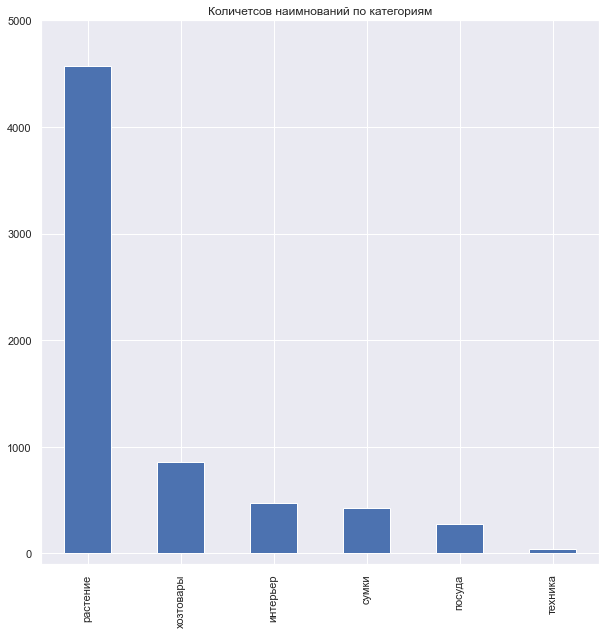

In [57]:
ax = df['category'].value_counts(ascending = False).plot(kind='bar', title = 'Количетсов наимнований по категориям', figsize = (10,10))
ax.set_ylim(-100, 5000)
plt.show()

Топ 5 клиентов.

Уберу вантузы, так как думаю, что это все таки выброс.

In [58]:
df_without_plumgers = df.query('product_total != 675000')

In [59]:
df_without_plumgers.loc[:,['customer_id', 'product_total']].groupby('customer_id').sum().sort_values('product_total', ascending=False).head()


product_total
customer_id                                        
c971fb21-d54c-4134-938f-16b62ee86d3b       166988.0
1d6c8c1f-a799-4418-9af2-1ded47d7a85c       114750.0
57cc80a2-2610-4eef-9457-e7c3bf0c72f0        65220.0
4d93d3f6-8b24-403b-a74b-f5173e40d7db        60828.0
58a4c3cc-504f-43ea-a74a-bae19e665552        53232.0

In [60]:
df_without_plumgers.loc[:,['customer_id', 'product_total']].groupby('customer_id').sum().sort_values('product_total', ascending=False).tail()


product_total
customer_id                                        
d5660bff-407f-463d-b2ff-e90a9ca05976           22.0
21df03ad-d9ac-47e9-a482-5372fd3e2464           22.0
2330d859-e9cb-4c8f-abd0-55f9e27e6745           15.0
f32b5708-af61-42e7-baba-9f3759d87841           15.0
cab090a5-b8dd-442d-a206-0ef3bf5fc1d8           14.0

Наблюдаем большой разброс. Это нам указывает, на то что есть оптовые покупатели.

In [61]:
pivot = df_without_plumgers.pivot_table(index = 'product', 
                                        aggfunc ={'customer_id':'nunique', 'quantity':'sum', 'product_total':'sum'})

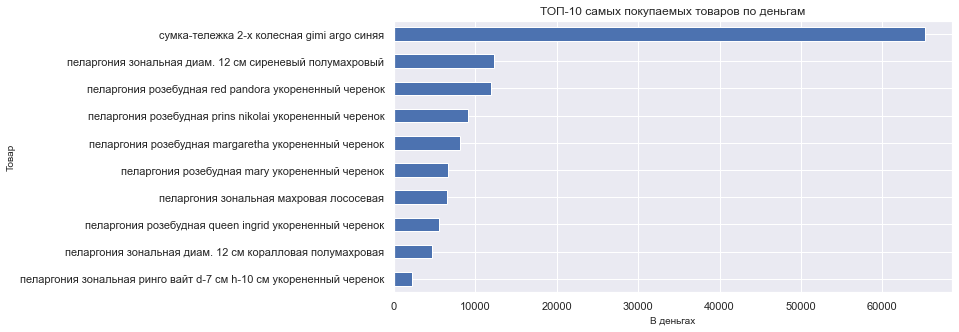

In [62]:
pivot.rename(columns={'customer_id':'unique_users'}, inplace=True)
pivot = pivot.sort_values(by= 'unique_users', ascending = False).head(10)
pivot['product_total'].sort_values(ascending= True).plot(kind="barh", figsize = (10,5), title = "ТОП-10 самых покупаемых товаров по деньгам")
plt.xlabel('В деньгах', fontsize=10) 
plt.ylabel('Товар', fontsize=10) 
plt.show()

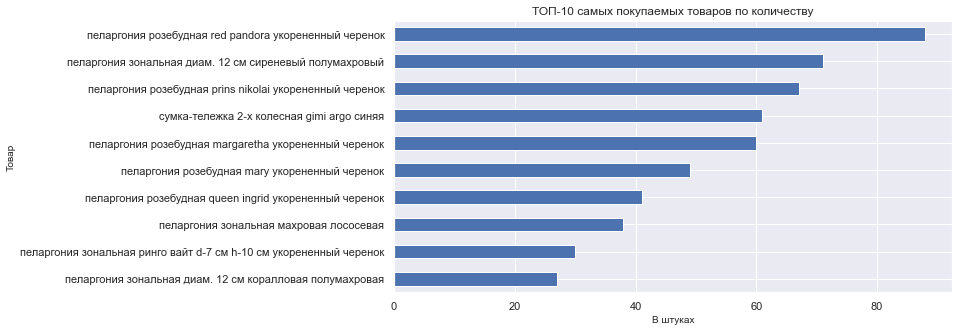

In [63]:
pivot['quantity'].sort_values(ascending= True).plot(kind="barh", figsize = (10,5), title = "ТОП-10 самых покупаемых товаров по количеству")
plt.xlabel('В штуках', fontsize=10) 
plt.ylabel('Товар', fontsize=10)
plt.show()

Выделю сезоны

In [64]:
def season(month):
    if  3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return "зима" 

In [65]:
df_without_plumgers['season'] = df_without_plumgers['month'].apply(season)


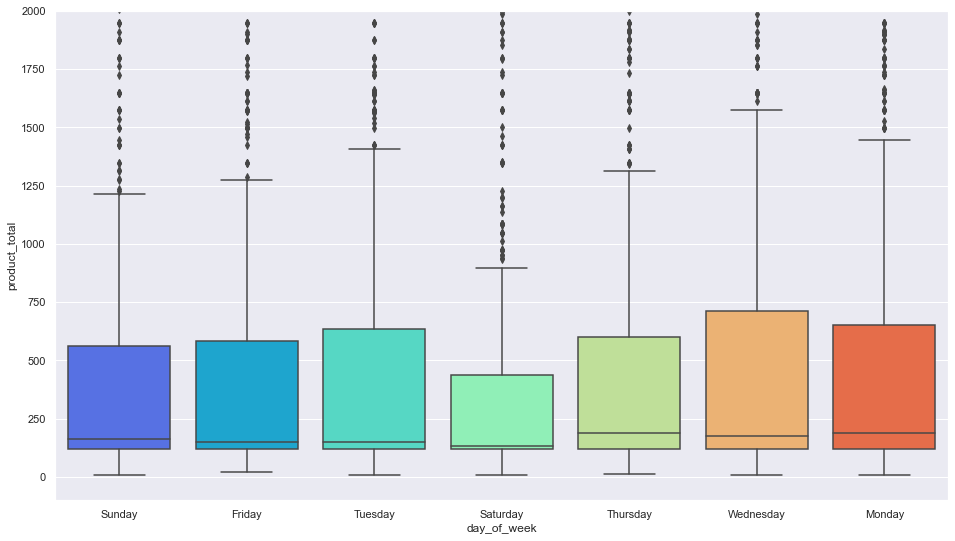

In [66]:
ax = sns.boxplot(x="day_of_week", y="product_total", data=df_without_plumgers, palette='rainbow')
ax.set_ylim(-100, 2000)
plt.show()

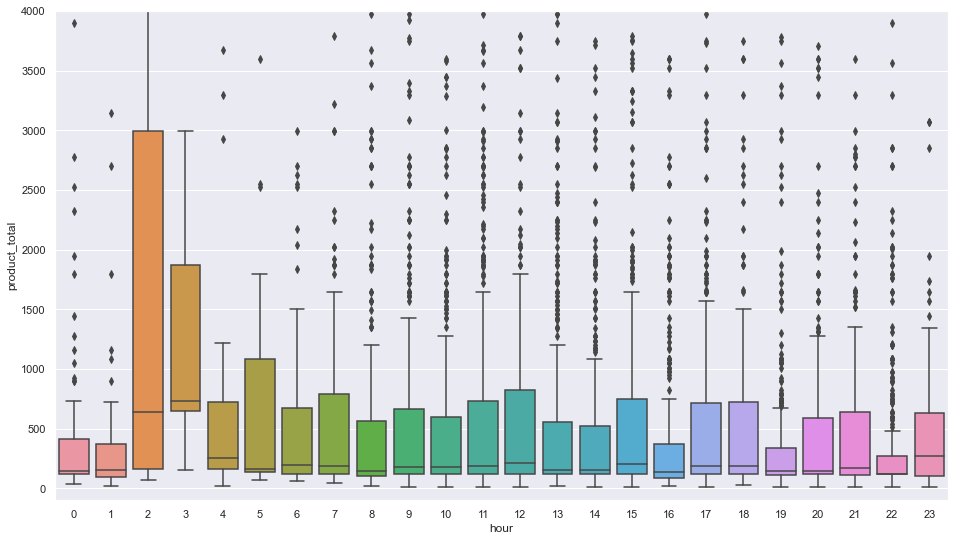

In [67]:
ax = sns.boxplot(x="hour", y="product_total", data=df_without_plumgers)
ax.set_ylim(-100, 4000)
plt.show()

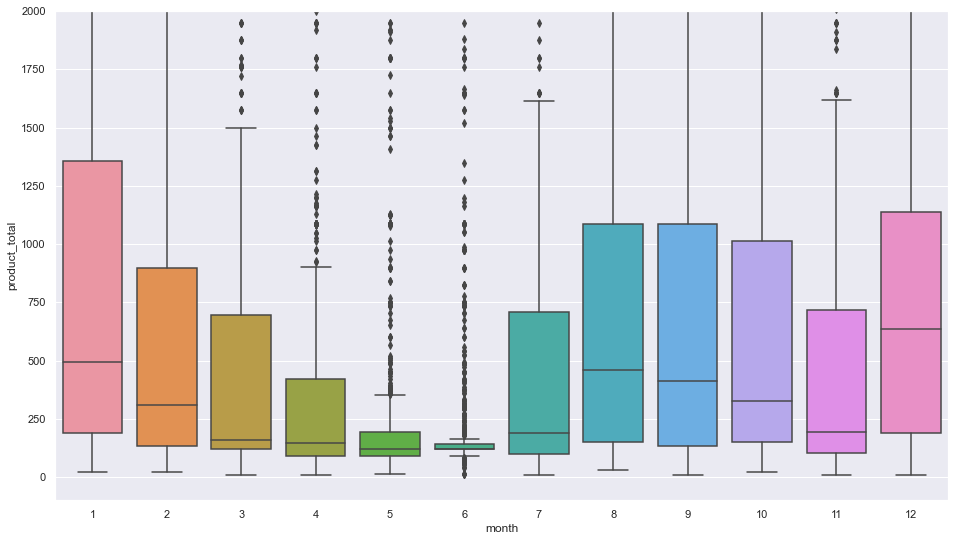

In [68]:
ax = sns.boxplot(x='month', y="product_total", data=df_without_plumgers)
ax.set_ylim(-100, 2000)
plt.show()

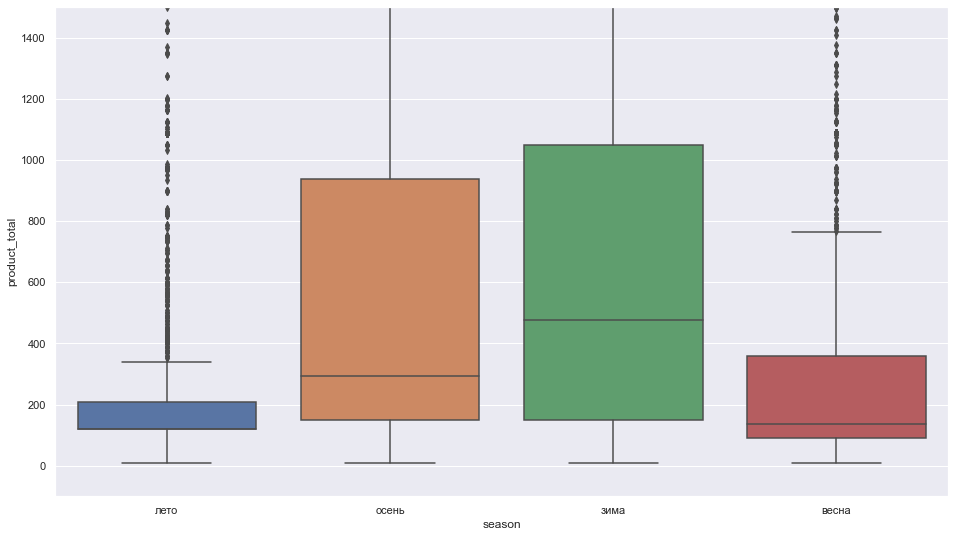

In [69]:
ax = sns.boxplot(x='season', y="product_total", data=df_without_plumgers)
ax.set_ylim(-100, 1500)
plt.show()

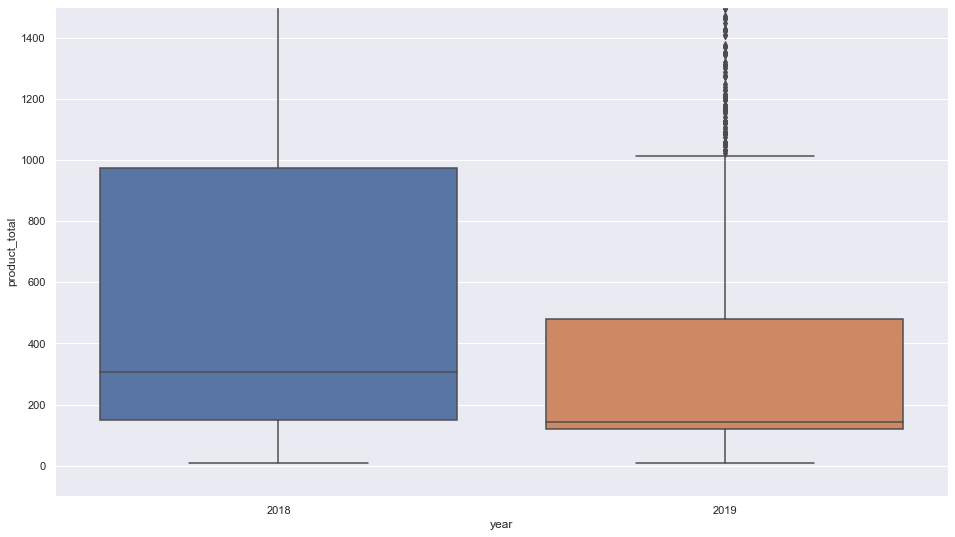

In [70]:
ax = sns.boxplot(x='year', y="product_total", data=df_without_plumgers)
ax.set_ylim(-100, 1500)
plt.show()

In [71]:
temp = df_without_plumgers.groupby(['category']).agg({'product_total': 'sum'})
temp.reset_index(inplace = True)
temp

category  product_total
0   интерьер       549160.0
1     посуда       210464.0
2   растение      1368339.0
3      сумки       818598.0
4    техника        36890.0
5  хозтовары      1099151.0

In [72]:
df_without_plumgers['category'].unique()

array(['растение', 'хозтовары', 'посуда', 'интерьер', 'сумки', 'техника'],
      dtype=object)

In [73]:
flowers = df_without_plumgers.query('category == "растение"')
household_goods = df_without_plumgers.query('category == "хозтовары"')
tableware = df_without_plumgers.query('category == "посуда"')
bags = df_without_plumgers.query('category == "сумки"')
interior_goods = df_without_plumgers.query('category == "интерьер"')
equipment = df_without_plumgers.query('category == "техника"')

Посмотрим на продажи по сезонам, месяцам и дням (раз нам дашборд строить так, то и тут решил сделать так)

## Анализ категорий

### Растения

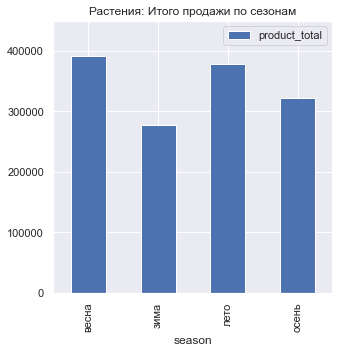

In [74]:
ax = flowers.groupby(['season']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Растения: Итого продажи по сезонам', figsize = (5,5))
ax.set_ylim(-100, 450000)
plt.show()

В целом логично, что зимой спад, так как зимой толком ничего и не растет. 

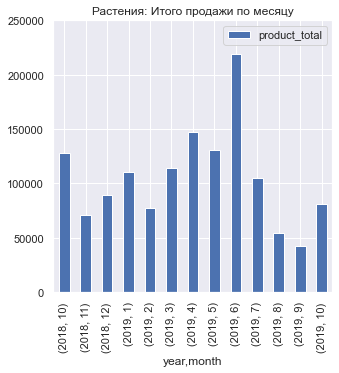

In [75]:
ax = flowers.groupby(['year', 'month']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Растения: Итого продажи по месяцу', figsize = (5,5))
ax.set_ylim(-100, 250000)
plt.show()

В 2019 года что-то пошло не так. Весна и лето показали себя хорошо.

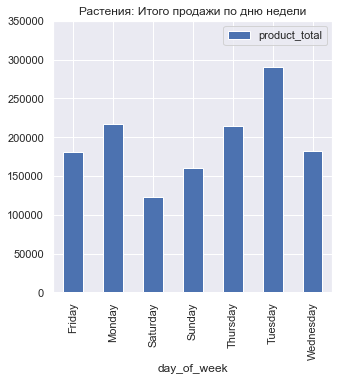

In [76]:
ax = flowers.groupby(['day_of_week']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Растения: Итого продажи по дню недели', figsize = (5,5))
ax.set_ylim(-100, 350000)
plt.show()

А вот тут неожиданно, что вторник показал самые высокие продажи. Я ожидал, что рост будет к концу недели и на выходных и вначале недели будет спад.

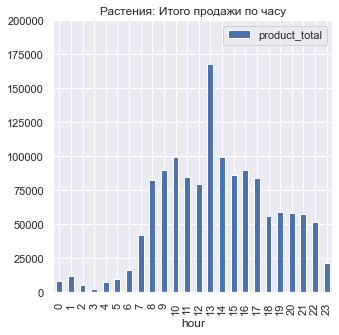

In [77]:
ax = flowers.groupby(['hour']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Растения: Итого продажи по часу', figsize = (5,5))
ax.set_ylim(-100, 200000)
plt.show()

Учитывая, что больше всего продаж во вторник, час дня кажется логичным, когда люди в обеденный перерыв закупаются.

### Хозтовары

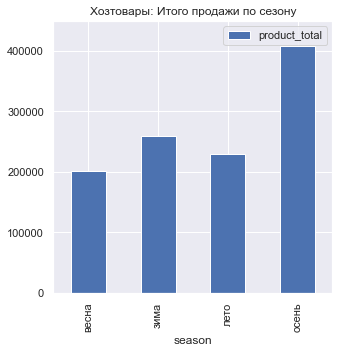

In [78]:
ax = household_goods.groupby(['season']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Хозтовары: Итого продажи по сезону', figsize = (5,5))
ax.set_ylim(-100, 450000)
plt.show()

Здесь лидер - осень. Зимой скорее всего покупают лопаты и что-то для уборки снега.

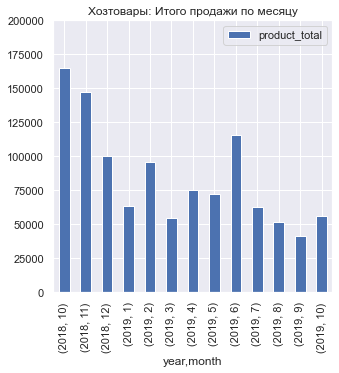

In [79]:
ax = household_goods.groupby(['year', 'month']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Хозтовары: Итого продажи по месяцу', figsize = (5,5))
ax.set_ylim(-100, 200000)
plt.show()

Опять видно падение в 2019 году.

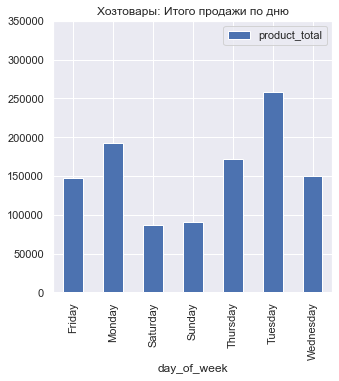

In [80]:
ax = household_goods.groupby(['day_of_week']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Хозтовары: Итого продажи по дню', figsize = (5,5))
ax.set_ylim(-100, 350000)
plt.show()

Опять лидер вторник. Возможно настроена какая-то рассылка по вторникам?

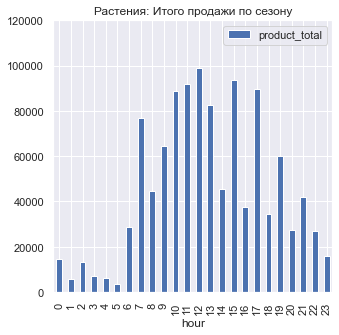

In [81]:
ax = household_goods.groupby(['hour']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Растения: Итого продажи по сезону', figsize = (5,5))
ax.set_ylim(-100, 120000)
plt.show()

Снова лидер - середина дня. Однако здесь еще неплозой рещультат показал 7 часов утра.

### Посуда

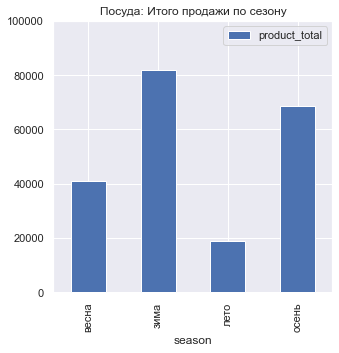

In [82]:
ax = tableware.groupby(['season']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Посуда: Итого продажи по сезону', figsize = (5,5))
ax.set_ylim(-100, 100000)
plt.show()

Видна просадка летом. 

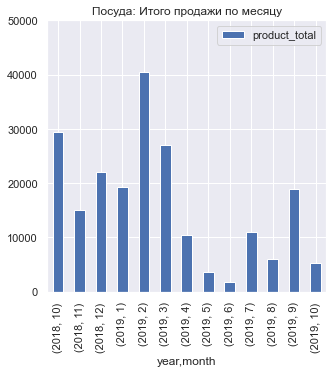

In [83]:
ax = tableware.groupby(['year', 'month']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Посуда: Итого продажи по месяцу', figsize = (5,5))
ax.set_ylim(-100, 50000)
plt.show()

Опять видна просадка в 2019 году.

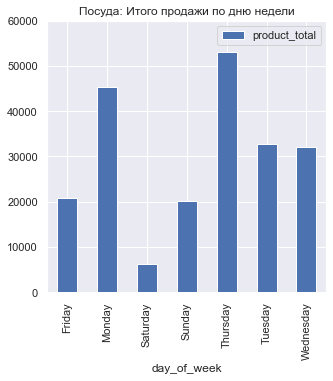

In [84]:
ax = tableware.groupby(['day_of_week']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Посуда: Итого продажи по дню недели', figsize = (5,5))
ax.set_ylim(-100, 60000)
plt.show()

Видна просадка в выходные, на неделе все хорошо. Лидер - вторник.

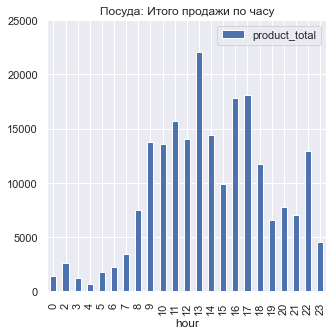

In [85]:
ax = tableware.groupby(['hour']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Посуда: Итого продажи по часу', figsize = (5,5))
ax.set_ylim(-100, 25000)
plt.show()

Снова в обед самый высокий показатель.

### Сумки

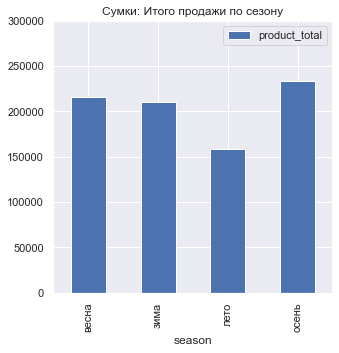

In [86]:
ax = bags.groupby(['season']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Сумки: Итого продажи по сезону', figsize = (5,5))
ax.set_ylim(-100, 300000)
plt.show()

Просадка летом. Остальные сезоны стаблильны.

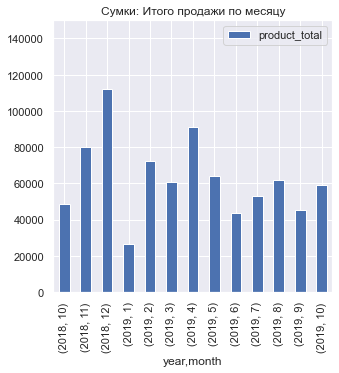

In [87]:
ax = bags.groupby(['year', 'month']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Сумки: Итого продажи по месяцу', figsize = (5,5))
ax.set_ylim(-100, 150000)
plt.show()

Падение в 2019 году

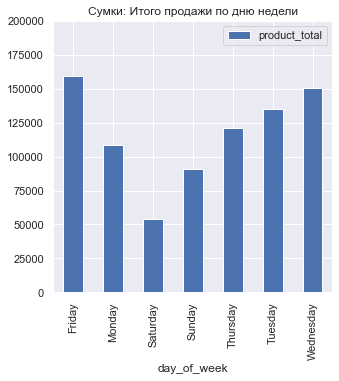

In [88]:
ax = bags.groupby(['day_of_week']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Сумки: Итого продажи по дню недели', figsize = (5,5))
ax.set_ylim(-100, 200000)
plt.show()

Тут лидер пятница. 

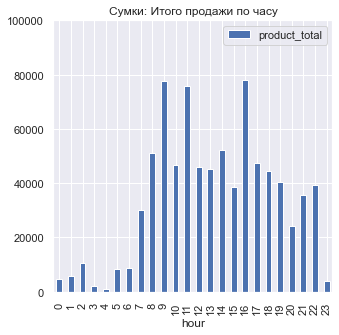

In [89]:
ax = bags.groupby(['hour']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Сумки: Итого продажи по часу', figsize = (5,5))
ax.set_ylim(-100, 100000)
plt.show()

Видим два пика: в 9 утра и в 16 часов вечера. 

### Интерьер

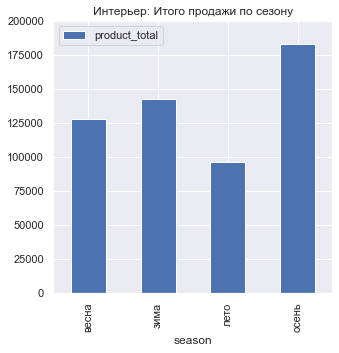

In [90]:
ax = interior_goods.groupby(['season']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Интерьер: Итого продажи по сезону', figsize = (5,5))
ax.set_ylim(-100, 200000)
plt.show()

Лидер - осень. Летом чуть хуже, но в целом небольшой разброс.

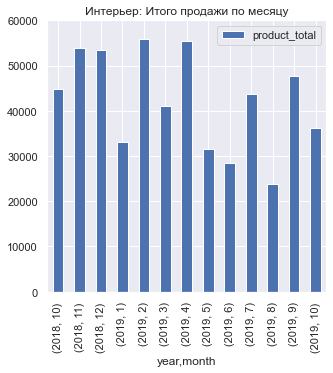

In [91]:
ax = interior_goods.groupby(['year', 'month']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Интерьер: Итого продажи по месяцу', figsize = (5,5))
ax.set_ylim(-100, 60000)
plt.show()

Спрос неустойчив.

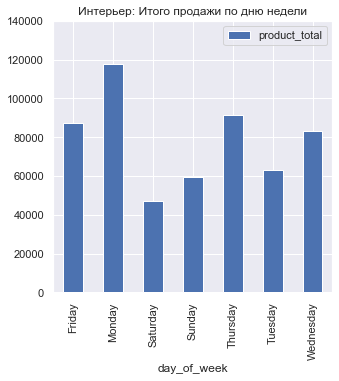

In [92]:
ax = interior_goods.groupby(['day_of_week']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Интерьер: Итого продажи по дню недели', figsize = (5,5))
ax.set_ylim(-100, 140000)
plt.show()

Больше всего покупают в понедельник. 

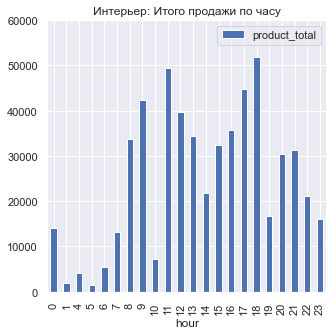

In [93]:
ax = interior_goods.groupby(['hour']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Интерьер: Итого продажи по часу', figsize = (5,5))
ax.set_ylim(-100, 60000)
plt.show()

Тут всплеск днем в 11 и вечером в 18

### Техника

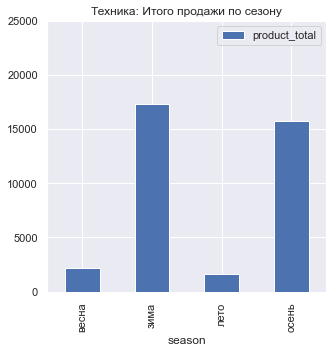

In [94]:
ax = equipment.groupby(['season']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Техника: Итого продажи по сезону', figsize = (5,5))
ax.set_ylim(-100, 25000)
plt.show()

летом и осенью огромные проблемы с продажами

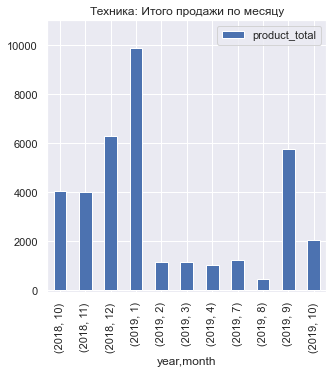

In [95]:
ax = equipment.groupby(['year', 'month']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Техника: Итого продажи по месяцу', figsize = (5,5))
ax.set_ylim(-100, 11000)
plt.show()

Были хорошие продажи в январе 2019, затем резкое падение. 

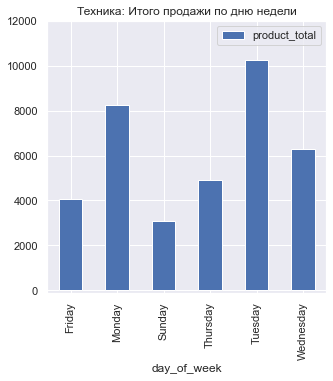

In [96]:
ax = equipment.groupby(['day_of_week']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Техника: Итого продажи по дню недели', figsize = (5,5))
ax.set_ylim(-100, 12000)
plt.show()

Тут, как и в большинстве случаев лидер - вторник. 

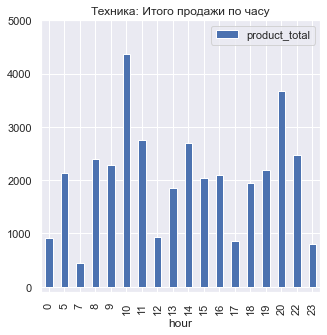

In [97]:
ax = equipment.groupby(['hour']).agg({'product_total': 'sum'}).plot(kind='bar', title = 'Техника: Итого продажи по часу', figsize = (5,5))
ax.set_ylim(-100, 5000)
plt.show()

Пик утром в 10.

## Вывод:

В целом динамика в 2019 году выглядит проблемно (везде спад). В основном лучший день недели продаж - вторник. Время в основном в обед. 

## Продажи суммарно по категориям.

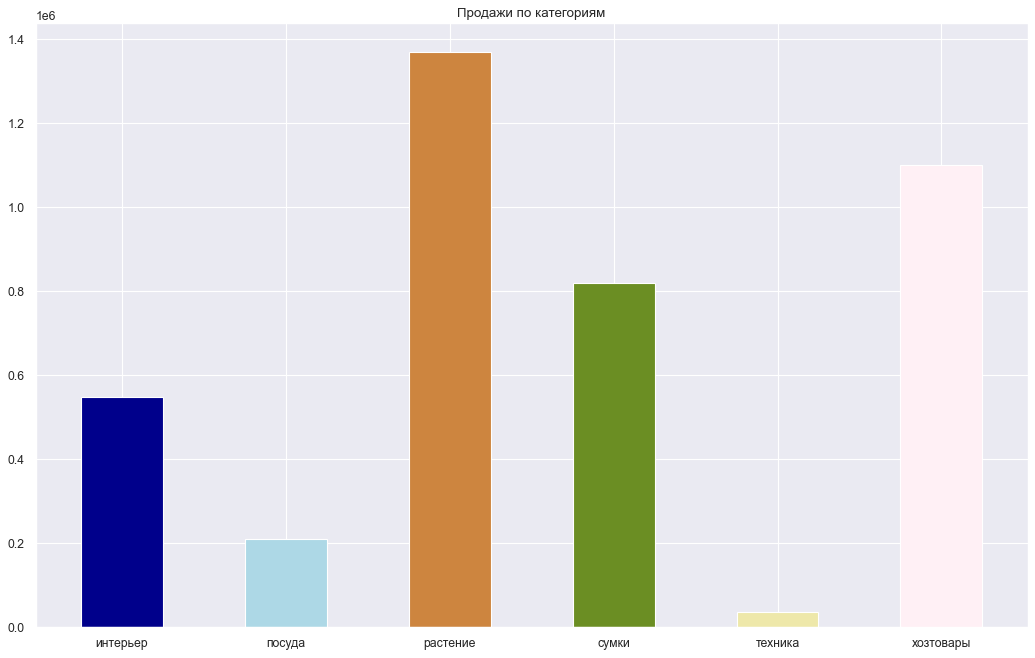

In [98]:
import random

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k = 6)

plt.figure(figsize=(16,10), dpi = 80)

plt.bar(temp['category'], temp['product_total'], color = c, width=.5)
plt.title('Продажи по категориям')
plt.show()

Больше всего приносят растения и хозтовары. Стоит сосредоточится на них. А вот техника совсем плохо идет. Возможно ее стоит убрать из ассортимента. 

In [99]:
temp = df_without_plumgers.groupby(['month_name', 'year'])['product_total'].sum().reset_index()


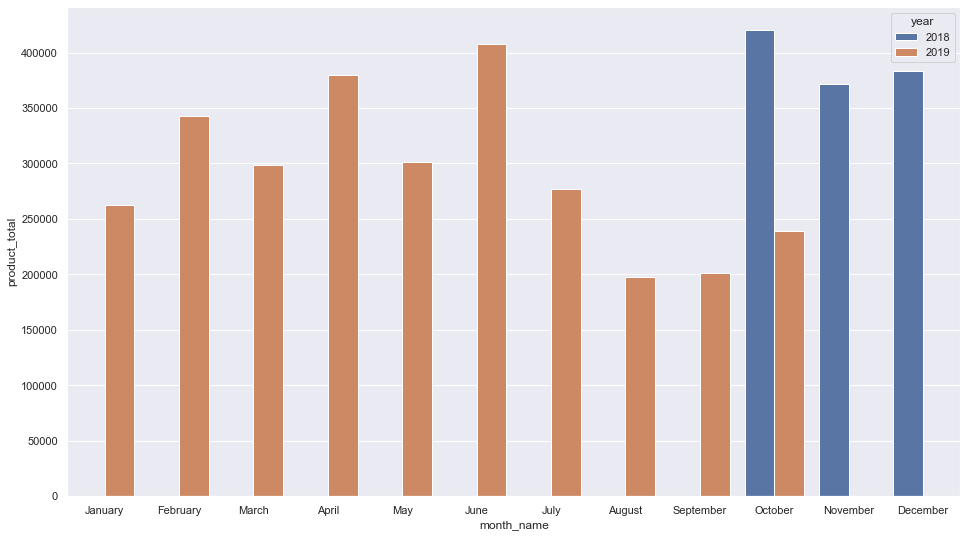

In [100]:
sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp)
plt.show()

В целом на общей картине так же видно, что продажи в 2019 по сравнению с 2018 упали. 

Построим ящики с усами.

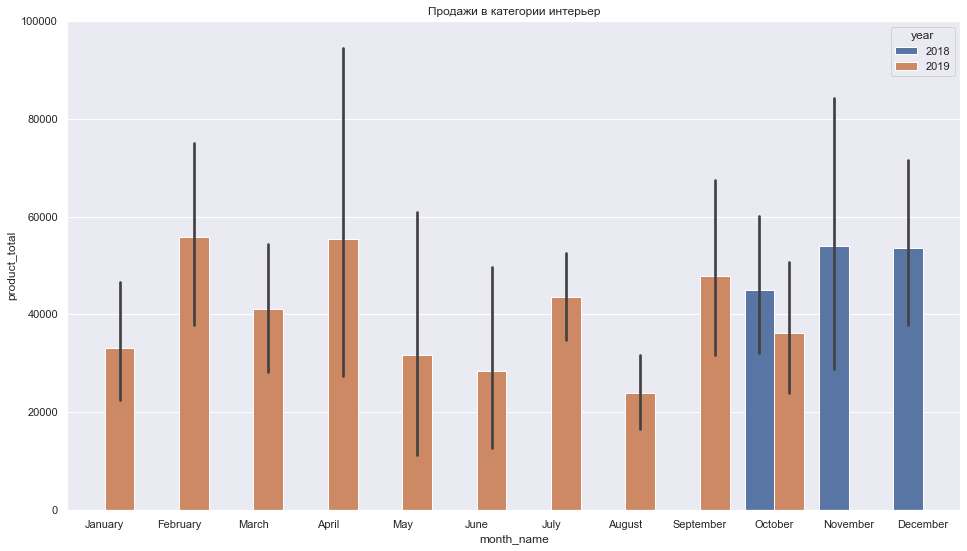

In [101]:
temp = df_without_plumgers.query('category == "интерьер"')
temp.groupby(['year', 'month']).agg({'product_total': 'sum'})
ax = sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp, estimator=sum)
plt.title('Продажи в категории интерьер')
ax.set_ylim(-100, 100000)
plt.show()

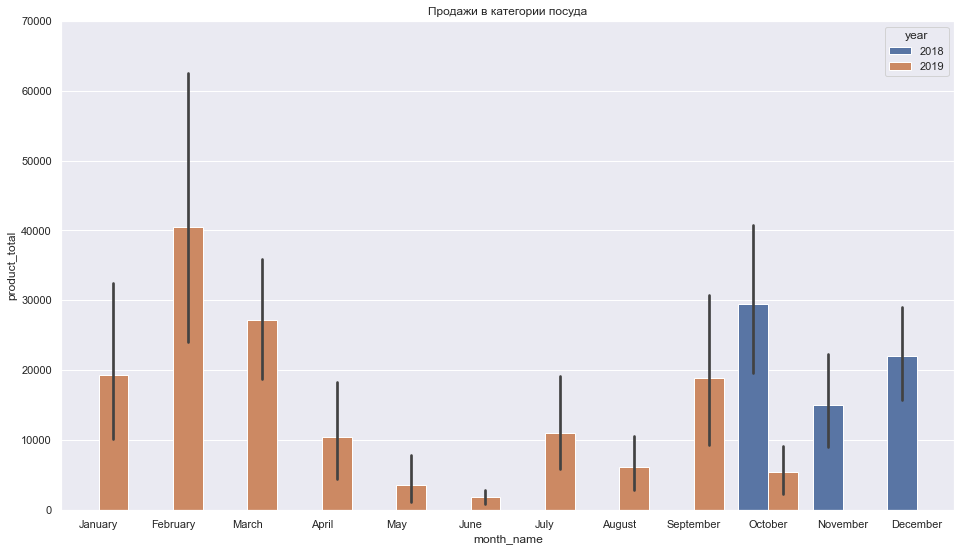

In [102]:
temp = df_without_plumgers.query('category == "посуда"')
temp.groupby(['year', 'month']).agg({'product_total': 'sum'})
ax = sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp, estimator=sum)
plt.title('Продажи в категории посуда')
ax.set_ylim(-100, 70000)
plt.show()

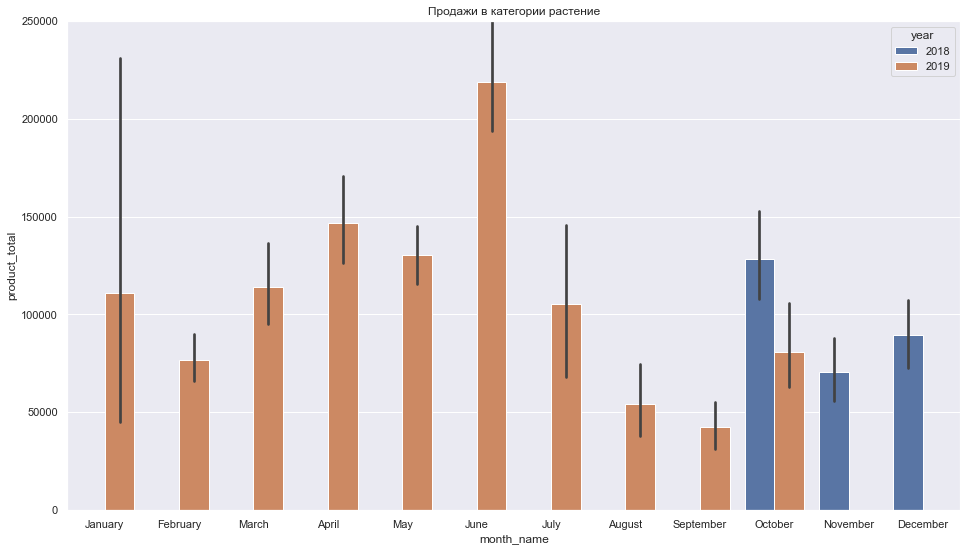

In [103]:
temp = df_without_plumgers.query('category == "растение"')
temp.groupby(['year', 'month']).agg({'product_total': 'sum'})
ax = sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp, estimator=sum)
plt.title('Продажи в категории растение')
ax.set_ylim(-100, 250000)
plt.show()

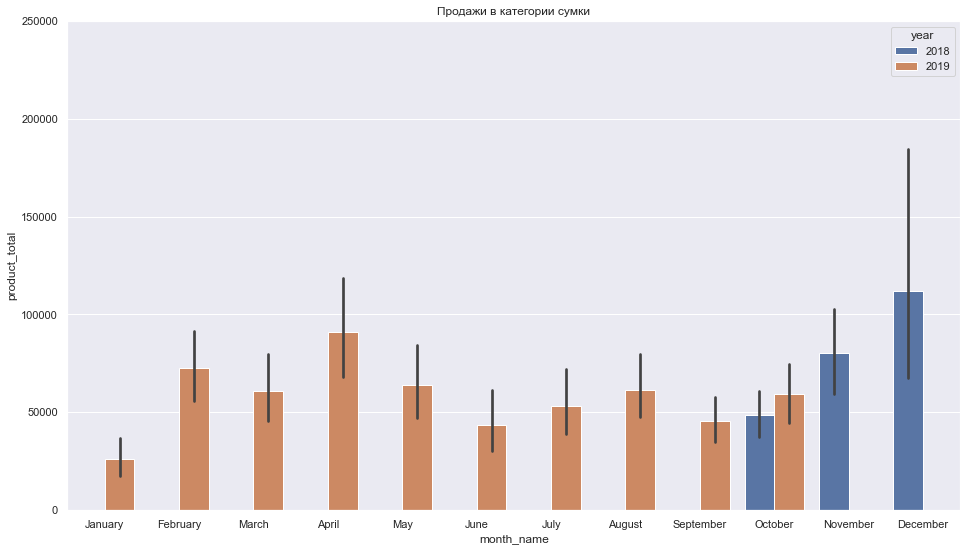

In [104]:
temp = df_without_plumgers.query('category == "сумки"')
temp.groupby(['year', 'month']).agg({'product_total': 'sum'})
ax = sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp, estimator=sum)
plt.title('Продажи в категории сумки')
ax.set_ylim(-100, 250000)
plt.show()

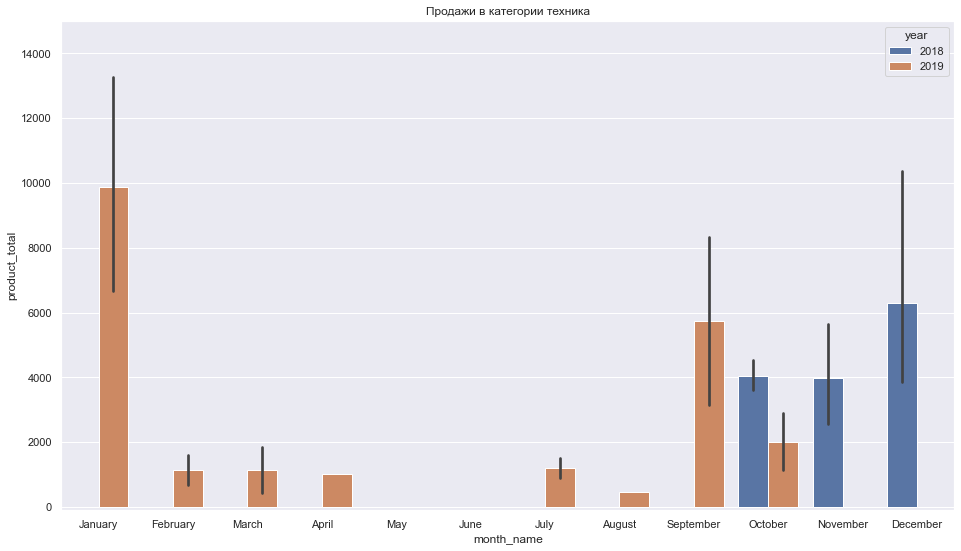

In [105]:
from numpy import median
temp = df_without_plumgers.query('category == "техника"')
temp.groupby(['year', 'month']).agg({'product_total': 'sum'})
ax = sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp, estimator=sum)
plt.title('Продажи в категории техника')
ax.set_ylim(-100, 15000)
plt.show()

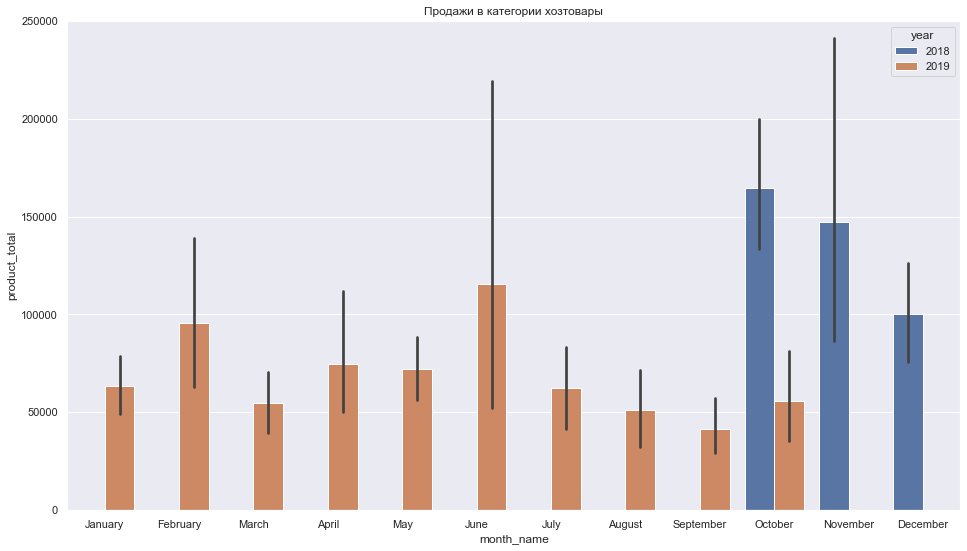

In [106]:
temp = df_without_plumgers.query('category == "хозтовары"')
temp.groupby(['year', 'month']).agg({'product_total': 'sum'})
ax = sns.barplot(x = 'month_name', y = 'product_total', hue = 'year', order =  month_order, data = temp, estimator=sum)
ax.set_ylim(-100, 250000)
plt.title('Продажи в категории хозтовары')
plt.show()

In [107]:
category_total = df_without_plumgers.pivot_table(index = ['category'], values = 'product_total', aggfunc = sum)
category_total

product_total
category                
интерьер        549160.0
посуда          210464.0
растение       1368339.0
сумки           818598.0
техника          36890.0
хозтовары      1099151.0

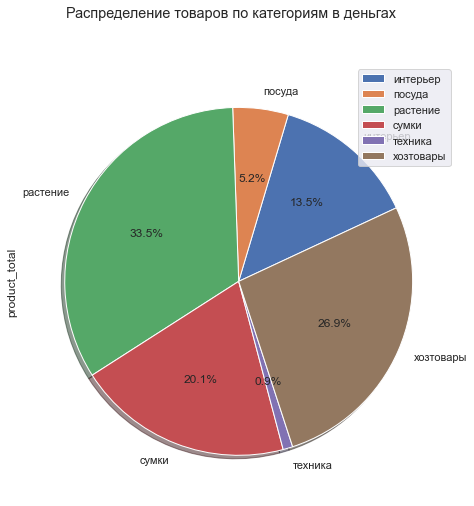

In [108]:
category_total.plot.pie(subplots=True, figsize=(8, 8), shadow = True, title = "Распределение товаров по категориям в деньгах", autopct='%1.1f%%', startangle=25)
plt.show()

В целом хозтаваров и растений много, они и показывают наибольший результат. 

In [109]:
dau = df_without_plumgers.groupby('date_day').agg({'customer_id': 'nunique'}).mean()
print('Количество уникальных пользователей в день:', int(dau), 'человек')

Количество уникальных пользователей в день: 7 человек


In [110]:
wau = df_without_plumgers.groupby(['year','week']).agg({'customer_id': 'nunique'}).mean()
print('Количество уникальных пользователей в неделю:', int(wau), 'человек')

Количество уникальных пользователей в неделю: 45 человек


In [111]:
mau = df_without_plumgers.groupby(['year','month']).agg({'customer_id': 'nunique'}).mean()
print('Количество уникальных пользователей в месяц:', int(mau), 'человек')

Количество уникальных пользователей в месяц: 189 человек


# Сегментация и класторизация

In [112]:
df2= df.loc[:,['customer_id', 'order_id']].groupby('customer_id').nunique()
df2

order_id
customer_id                                   
000d6849-084e-4d9f-ac03-37174eaf60c4         1
001cee7f-0b29-4716-b202-0042213ab038         1
00299f34-5385-4d13-9aea-c80b81658e1b         1
002d4d3a-4a59-406b-86ec-c3314357e498         1
003bbd39-0000-41ff-b7f9-2ddaec152037         1
...                                        ...
ff601403-b094-4b86-9ac6-264d725b9277         1
ffaeab76-3a8d-49ee-860f-17273b2fc8a2         1
ffb5976a-7a4d-460b-95c4-5ffaba31cb24         1
ffb80538-3fda-4351-8ea9-9d2bec58bb07         1
ffe82299-3f5b-4214-87fe-3d36ecccfac3         1

[2394 rows x 1 columns]

In [113]:
df2['order_id'].unique()

array([  1,   5,   2,   3,   4,  35,  17,   7, 126])

In [114]:
df_without_plumgers = df_without_plumgers.merge(df2, on='customer_id', how='left')
pd.set_option('display.max_columns', None)
df_without_plumgers = df_without_plumgers.rename(columns={'order_id_x': 'order_id','order_id_y':'count_orders'})

df_without_plumgers

order_id                date                           customer_id  \
0        12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
1        12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
2        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
3        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
4        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
...        ...                 ...                                   ...   
6642     73155 2019-10-31 11:00:00  f17ed857-178e-45e1-a662-0a9dd3b58c5f   
6643     73156 2019-10-31 11:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58   
6644     73158 2019-10-31 12:00:00  1f0a7f35-7459-4f23-b468-5e45bf481dd1   
6645     73162 2019-10-31 13:00:00  25df96a7-c453-4708-9cea-a3dfc7c342ea   
6646     73164 2019-10-31 14:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58   

                                                product  quantity   price  \
0                   осина обыкновенная, высота 25-50 см         1   150.0   
1                  осина обыкновенная, высота 50-100 см         1   225.0   
2     рассада зелени для кухни лаванды в кассете по ...         1   315.0   
3     рассада зелени для кухни розмарина в кассете п...         1   207.0   
4     рассада зелени для кухни тимьяна в кассете по ...         1   162.0   
...                                                 ...       ...     ...   
6642                            мимоза стыдливая d-9 см         1   329.0   
6643  таз пластмассовый 40,0 л пищевой овальный (иж)...         1   404.0   
6644         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   
6645  герань домашняя (пеларгония зональная) цветуща...         1   157.0   
6646  таз пластмассовый со стиральной доской (иж), 1...         1   397.0   

      hour day_of_week    date_day  week month_name  month  year  \
0       20      Sunday  2019-06-02    22       June      6  2019   
1       20      Sunday  2019-06-02    22       June      6  2019   
2        0      Friday  2018-10-05    40    October     10  2018   
3        0      Friday  2018-10-05    40    October     10  2018   
4        0      Friday  2018-10-05    40    October     10  2018   
...    ...         ...         ...   ...        ...    ...   ...   
6642    11    Thursday  2019-10-31    44    October     10  2019   
6643    11    Thursday  2019-10-31    44    October     10  2019   
6644    12    Thursday  2019-10-31    44    October     10  2019   
6645    13    Thursday  2019-10-31    44    October     10  2019   
6646    14    Thursday  2019-10-31    44    October     10  2019   

      product_total  word_count product_2_first_words product_first_word  \
0             150.0           5    осина обыкновенная              осина   
1             225.0           5    осина обыкновенная              осина   
2             315.0          10        рассада зелени            рассада   
3             207.0          10        рассада зелени            рассада   
4             162.0          10        рассада зелени            рассада   
...             ...         ...                   ...                ...   
6642          329.0           4      мимоза стыдливая             мимоза   
6643          404.0           8     таз пластмассовый                таз   
6644         1087.0           6     сумка-тележка 2-х      сумка-тележка   
6645          157.0          11       герань домашняя             герань   
6646          397.0           7     таз пластмассовый                таз   

       category season  count_orders  
0      растение   лето             1  
1      растение   лето             1  
2      растение  осень             1  
3      растение  осень             1  
4      растение  осень             1  
...         ...    ...           ...  
6642   растение  осень             1  
6643  хозтовары  осень            17  
6644      сумки  осень             1  
6645   растение  осень             1  
6646  хоз

In [115]:
def one_order(count_orders):
    if  count_orders == 1:
        return 1
    else:
        return 0

In [116]:
def more_1_order(count_orders):
    if count_orders != 1:
        return 1
    else:
        return 0 

In [117]:
df_without_plumgers['one_order'] = df_without_plumgers['count_orders'].apply(one_order)
df_without_plumgers['more_1_order'] = df_without_plumgers['count_orders'].apply(more_1_order)
df_without_plumgers

order_id                date                           customer_id  \
0        12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
1        12624 2019-06-02 20:00:00  d17861fa-db5f-4de4-93fd-dc5e60d24d3e   
2        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
3        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
4        13547 2018-10-05 00:00:00  b80e4826-7218-4bf9-ac08-eb2c81ab3f62   
...        ...                 ...                                   ...   
6642     73155 2019-10-31 11:00:00  f17ed857-178e-45e1-a662-0a9dd3b58c5f   
6643     73156 2019-10-31 11:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58   
6644     73158 2019-10-31 12:00:00  1f0a7f35-7459-4f23-b468-5e45bf481dd1   
6645     73162 2019-10-31 13:00:00  25df96a7-c453-4708-9cea-a3dfc7c342ea   
6646     73164 2019-10-31 14:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58   

                                                product  quantity   price  \
0                   осина обыкновенная, высота 25-50 см         1   150.0   
1                  осина обыкновенная, высота 50-100 см         1   225.0   
2     рассада зелени для кухни лаванды в кассете по ...         1   315.0   
3     рассада зелени для кухни розмарина в кассете п...         1   207.0   
4     рассада зелени для кухни тимьяна в кассете по ...         1   162.0   
...                                                 ...       ...     ...   
6642                            мимоза стыдливая d-9 см         1   329.0   
6643  таз пластмассовый 40,0 л пищевой овальный (иж)...         1   404.0   
6644         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   
6645  герань домашняя (пеларгония зональная) цветуща...         1   157.0   
6646  таз пластмассовый со стиральной доской (иж), 1...         1   397.0   

      hour day_of_week    date_day  week month_name  month  year  \
0       20      Sunday  2019-06-02    22       June      6  2019   
1       20      Sunday  2019-06-02    22       June      6  2019   
2        0      Friday  2018-10-05    40    October     10  2018   
3        0      Friday  2018-10-05    40    October     10  2018   
4        0      Friday  2018-10-05    40    October     10  2018   
...    ...         ...         ...   ...        ...    ...   ...   
6642    11    Thursday  2019-10-31    44    October     10  2019   
6643    11    Thursday  2019-10-31    44    October     10  2019   
6644    12    Thursday  2019-10-31    44    October     10  2019   
6645    13    Thursday  2019-10-31    44    October     10  2019   
6646    14    Thursday  2019-10-31    44    October     10  2019   

      product_total  word_count product_2_first_words product_first_word  \
0             150.0           5    осина обыкновенная              осина   
1             225.0           5    осина обыкновенная              осина   
2             315.0          10        рассада зелени            рассада   
3             207.0          10        рассада зелени            рассада   
4             162.0          10        рассада зелени            рассада   
...             ...         ...                   ...                ...   
6642          329.0           4      мимоза стыдливая             мимоза   
6643          404.0           8     таз пластмассовый                таз   
6644         1087.0           6     сумка-тележка 2-х      сумка-тележка   
6645          157.0          11       герань домашняя             герань   
6646          397.0           7     таз пластмассовый                таз   

       category season  count_orders  one_order  more_1_order  
0      растение   лето             1          1             0  
1      растение   лето             1          1             0  
2      растение  осень             1          1             0  
3      растение  осень             1          1             0  
4      растение  осень             1          1             0  
...         ...    ...           ...        ...       

In [118]:
df_without_plumgers['count_orders'].unique()

array([  1,   2,   3,   7,   5,   4, 126,  35,  17])

In [119]:
pd.set_option('display.max_rows', None)

In [120]:
clusters = df_without_plumgers.pivot_table(index = 'customer_id', aggfunc = {'order_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
clusters['average_check'] = clusters['product_total'] / clusters['quantity']
clusters

order_id         price  product_total  \
customer_id                                                                   
000d6849-084e-4d9f-ac03-37174eaf60c4         1    138.750000          555.0   
001cee7f-0b29-4716-b202-0042213ab038         1    442.000000          442.0   
00299f34-5385-4d13-9aea-c80b81658e1b         1    457.000000          914.0   
002d4d3a-4a59-406b-86ec-c3314357e498         1   1649.000000         1649.0   
003bbd39-0000-41ff-b7f9-2ddaec152037         1   1162.000000         2324.0   
004d24e9-4a6c-4d0e-8727-8391dfd4b43a         1    128.000000         1536.0   
005ba170-45e8-42de-93f7-192481ae2659         1   1199.000000         1199.0   
00bd74b1-2792-47db-a2f1-680a09ac5026         1    937.000000          937.0   
00c0f92a-121a-4883-a78d-2c7b5fe187de         1    134.000000          134.0   
00cd704a-a65c-4865-b39a-779f1b4f1d1a         1    112.000000          112.0   
00e59a12-06d5-47fc-9a33-bfc53aca1e9f         1    899.000000         1798.0   
00ff5327-0fba-481c-8a07-47a95093a213         1   1049.000000         1049.0   
0114e87e-78e2-49bf-9c8c-bbddd7191a3f         1    974.000000          974.0   
0131d2f9-e553-4cb6-ac85-f96e9cb7cb47         1   1574.000000         1574.0   
0161a155-59b3-4613-a6ff-2e6bfcc00463         1   2699.000000         2699.0   
01626eda-0717-4a39-826e-1982a358576d         1    599.000000          599.0   
0184f535-b60a-4914-a982-231e3f615206         5    109.063830         7707.0   
018dc738-2846-464d-a421-126a8ed64bc5         1     94.000000          940.0   
018fb729-3525-4314-8e4d-1982b1062f9f         1     44.000000         4400.0   
019ddfb4-f9fe-4b17-88bb-0ec9edb56479         1   2549.000000         5098.0   
01a53da1-c3ae-47cf-916e-7e345fe2f2bc         1   2924.000000         2924.0   
01bd5b9a-2b4e-483c-95a3-40b040c392e8         1     52.857143          408.0   
01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33         1   1696.666667         5090.0   
01ca3206-da26-470d-8240-f34e7086c214         1    157.000000          157.0   
01f95d43-4a8d-45e5-9c23-cccd211e6d30         1     44.000000           44.0   
022ecd2e-bc6c-4e78-938e-b9e4bc526271         1    118.857143         1214.0   
02477bed-bad4-482f-9e47-80d7f6d77c7b         1    524.000000          524.0   
02648fcc-ab94-4f94-ad3b-fbaef270d001         1   1912.000000         1912.0   
0279a2cc-6bd4-4004-bc6c-cf43ec9bdeee         1    157.000000          157.0   
028469c0-9e87-4596-ac2e-c5b1d48ea9b6         1     26.000000         2340.0   
02a27adc-a1fe-4aaf-9945-1ab779979537         1     45.000000           45.0   
02adb72a-3067-45e9-a3b5-f93d79d7496a         2   5361.500000        10723.0   
02cb74c5-348f-43dc-ba4d-e546a21a07f1         1    134.000000          134.0   
030c91b7-311d-407e-a3ac-e64c03537569         1    150.000000          150.0   
03134fa3-9ce0-4973-849d-32c21e26d64e         1   1177.000000         1177.0   
03427797-398e-497d-a303-48879e7ba7f7         1    525.000000          525.0   
034ed71f-ad8c-4891-848b-297a64c9ec22         1    329.000000          658.0   
036118cf-c198-48fa-ba15-6d841482a56d         2    112.000000         1926.0   
036d75ea-b633-41a8-8974-3f84fee8c65e         1   2399.000000         2399.0   
036edc2c-d0ad-4c71-99f6-226db1b883f4         1    239.000000         1195.0   
03865a43-8c19-4d4e-ab51-7ec516614a83         1    135.000000          540.0   
03b7b4a5-9e2c-42f9-a131-96f3d2772f17         1   1574.000000         1574.0   
03bdfd0d-218d-4572-b623-36baa274a9ea         1   4874.000000         4874.0   
03d875f5-1100-45be-9979-6269a8573c00         1   1049.000000         1049.0   
04416514-5346-4f90-93e3-fb7365e2ee8c         1     30.000000           30.0   
04c9031f-1248-4fd9-add0-6c5a4efaa58e         1    599.000000          599.0   
04d4b824-7b31-4262-8aa0-e43772602521         1    734.000000          734.0   
04f4acb1-8c6d-4e1c-a960-3fa400d220a7         1   1874.000000         1874.0   
051d78d4-3667-4018-90d5-2e7ae8c98816         1    727.000000          727.0   
051edfd2-

In [121]:
print(np.percentile(clusters['order_id'], [90, 95, 99]))

[1. 2. 3.]


In [122]:
print(np.percentile(clusters['price'], [90, 95, 99]))

[1941.6  2999.   5949.88]


In [123]:
print(np.percentile(clusters['product_total'], [90, 95, 99]))

[ 3432.2   5093.2  12329.68]


In [124]:
print(np.percentile(clusters['quantity'], [90, 95, 99]))

[11.  25.  75.4]


Количество выше 25 считаю выбросом, так как лишь 1% пользователей купил больше.

In [125]:
print(np.percentile(clusters['average_check'], [90, 95, 99]))

[1941.6  2999.   5949.88]


In [126]:
clusters = clusters.query('quantity < 26')

In [127]:
# создаём объект класса scaler
scaler = StandardScaler() 
# обучаем нормализатор и преобразуем набор данных
x_sc = scaler.fit_transform(clusters)

In [128]:
linked = linkage(x_sc, method = 'ward')

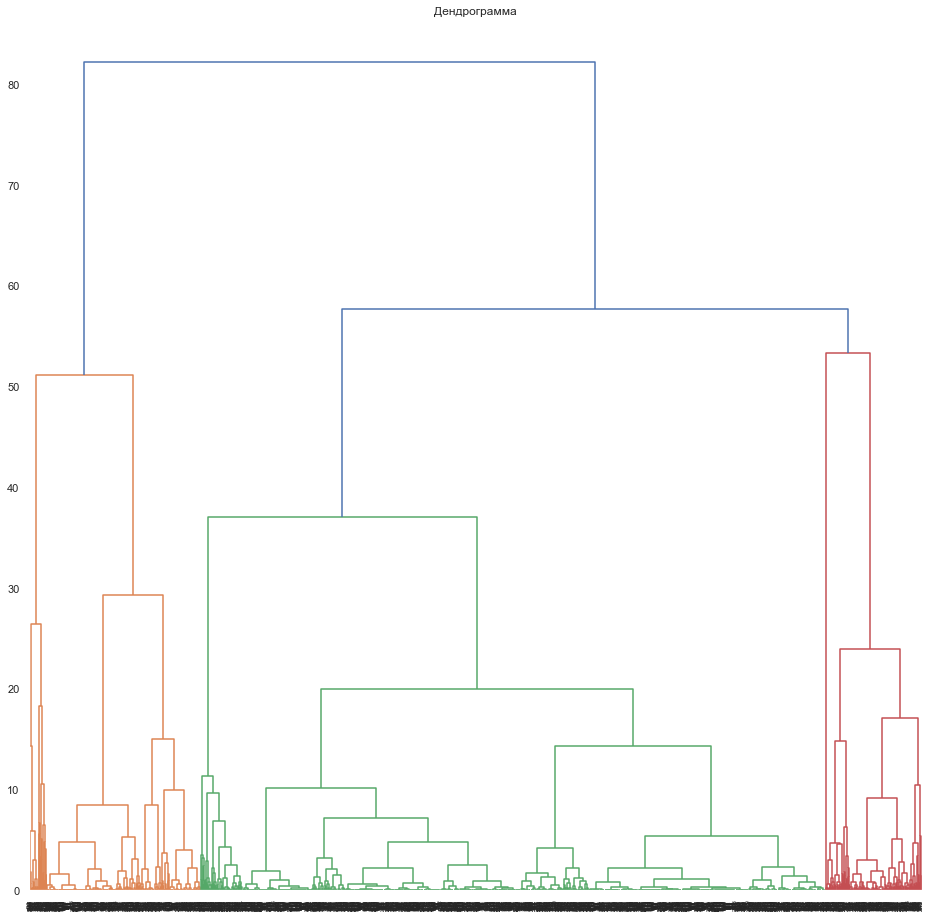

In [129]:
plt.figure(figsize=(16, 16))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

In [130]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3)

# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
clusters['cluster_km'] = labels

In [131]:
cluster_km_mean = clusters.groupby(['cluster_km']).mean()
cluster_km_mean.T

cluster_km               0            1           2
order_id          1.066038     1.243028    1.050577
price          3725.597091   140.160713  561.607204
product_total  5320.863208  1728.151394  789.818582
quantity          1.683962    13.498008    1.799340
average_check  3725.606525   135.056137  561.225567

## Проверка гипотезы

In [132]:
alpha = 0.05# ваш код

results = st.shapiro(clusters)# ваш код
p_value = p_value = results[
    1
]# ваш код

print('p-значение: ', p_value)

if p_value < alpha:# ваш код
    print('Отвергаем нулевую гипотезу: распределение не нормально')# ваш код
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


### Гипотеза


H0: Нет различий среди количества купленных товаров между кластерами

H1: Есть различий среди количества купленных товаров между кластерами

In [133]:
alpha = 0.05  # критический уровень статистической значимости

results_AB = st.mannwhitneyu(clusters.loc[clusters.loc[:,'cluster_km'] == 0]['product_total'], clusters.loc[clusters.loc[:,'cluster_km'] == 1]['product_total'])

results_BC = st.mannwhitneyu(clusters.loc[clusters.loc[:,'cluster_km'] == 1]['product_total'], clusters.loc[clusters.loc[:,'cluster_km'] == 2]['product_total'])

results_AC = st.mannwhitneyu(clusters.loc[clusters.loc[:,'cluster_km'] == 0]['product_total'], clusters.loc[clusters.loc[:,'cluster_km'] == 2]['product_total'])

bonferroni_alpha = alpha / 3  # произведено три сравнения

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп А и C: ', results_AC.pvalue)

if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_BC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_AC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    )

p-значение для сравнения групп А и B:  3.3050325505998784e-55
p-значение для сравнения групп B и C:  8.948319251773606e-34
p-значение для сравнения групп А и C:  5.9631697264615836e-120
Отвергаем нулевую гипотезу для сравнения групп А и B
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп А и C


### Гипотеза

Вторая гипотеза:
H0: Нет различий среднего чека между кластерами

H1: Есть различий среднего чека между кластерами

In [134]:
alpha = 0.05  # критический уровень статистической значимости

results_AB = st.mannwhitneyu(clusters.loc[clusters.loc[:,'cluster_km'] == 0]['average_check'], clusters.loc[clusters.loc[:,'cluster_km'] == 1]['average_check'])

results_BC = st.mannwhitneyu(clusters.loc[clusters.loc[:,'cluster_km'] == 1]['average_check'], clusters.loc[clusters.loc[:,'cluster_km'] == 2]['average_check'])

results_AC = st.mannwhitneyu(clusters.loc[clusters.loc[:,'cluster_km'] == 0]['average_check'], clusters.loc[clusters.loc[:,'cluster_km'] == 2]['average_check'])

bonferroni_alpha = alpha / 3  # произведено три сравнения

print('p-значение для сравнения групп А и B: ', results_AB.pvalue)
print('p-значение для сравнения групп B и C: ', results_BC.pvalue)
print('p-значение для сравнения групп А и C: ', results_AC.pvalue)

if results_AB.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )

if results_BC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп B и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп B и C'
    )

if results_AC.pvalue < bonferroni_alpha:
    print('Отвергаем нулевую гипотезу для сравнения групп А и C')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и C'
    ) 

p-значение для сравнения групп А и B:  8.514986226675912e-77
p-значение для сравнения групп B и C:  8.488545496943864e-58
p-значение для сравнения групп А и C:  9.897340488994814e-124
Отвергаем нулевую гипотезу для сравнения групп А и B
Отвергаем нулевую гипотезу для сравнения групп B и C
Отвергаем нулевую гипотезу для сравнения групп А и C


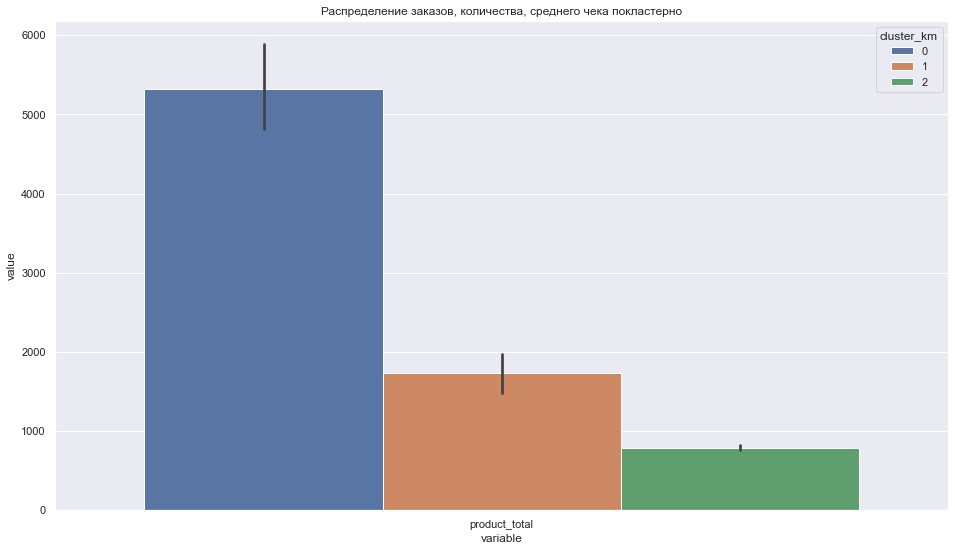

In [135]:
plt.figure(figsize = (16,9))
melted = pd.melt(clusters, id_vars = ['cluster_km'], value_vars = ['product_total'])
ax = sns.barplot(x = 'variable' , y = 'value',  hue = 'cluster_km', data = melted)
plt.title('Распределение заказов, количества, среднего чека покластерно')
plt.show()

In [136]:
cluster_0 = clusters.query('cluster_km == 0')
cluster_0

order_id         price  product_total  \
customer_id                                                                   
0161a155-59b3-4613-a6ff-2e6bfcc00463         1   2699.000000         2699.0   
019ddfb4-f9fe-4b17-88bb-0ec9edb56479         1   2549.000000         5098.0   
01a53da1-c3ae-47cf-916e-7e345fe2f2bc         1   2924.000000         2924.0   
01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33         1   1696.666667         5090.0   
02adb72a-3067-45e9-a3b5-f93d79d7496a         2   5361.500000        10723.0   
036d75ea-b633-41a8-8974-3f84fee8c65e         1   2399.000000         2399.0   
03bdfd0d-218d-4572-b623-36baa274a9ea         1   4874.000000         4874.0   
05257dd3-0c7e-4b4c-a86d-786558162d11         1   3599.000000         3599.0   
0663dccc-7ca4-48ec-8eef-a3cae84ec407         1   2849.000000         2849.0   
06a80fd5-29ea-4204-a7df-de6b6c30119a         1   3719.000000         3719.0   
06e2fc7e-6183-4419-ada4-3b976baeed92         1   5474.000000         5474.0   
07c067bd-5df0-4291-872c-54cae69e4519         1   3224.000000         3224.0   
07e68a7f-22ed-4c8a-b0d1-79ba886a1be0         1   2474.000000         2474.0   
092ef2d7-30d2-4d15-9c40-35af6973f28b         1   2324.000000         2324.0   
09bcc3d0-8134-4f00-8ea5-b74b55d766ad         1   5549.000000        16647.0   
0b09525a-e826-4d5f-9042-58999e1057ec         1   3712.000000         3712.0   
0d87f4ae-465a-4fac-81e6-5d629761783e         1  14917.000000        14917.0   
0e668f0e-582c-4832-a9a7-9dd667c26900         1   6449.000000         6449.0   
0f852900-befa-4577-896e-1c01d2034377         1   2924.000000         2924.0   
11394ce3-31bd-4d86-a9d6-4f7661cd96eb         1   2549.000000         5098.0   
126dac4d-6486-49ed-a1be-9fd55a38a9de         2   4574.000000         9148.0   
13b0ef12-237d-4779-970c-4f453e9337a3         1   3299.000000         3299.0   
13ff36b4-cbf6-491e-9801-765785a1a2fd         1   4859.000000         4859.0   
14f49722-d88f-4167-9cd9-6eefc2ad0636         1   2699.000000         2699.0   
16838b36-762a-474d-bda4-bad95f8d7813         1   7229.000000         7229.0   
16e422c6-94fe-4ccf-9c97-05493f3e99c4         1   5399.000000         5399.0   
19d904d8-8d16-476d-8f66-b2a3b7a23660         1   8077.000000         8077.0   
19ef25d1-7031-420f-85ac-4f87e8357503         1   2549.000000         2549.0   
1a32c1a4-5862-4896-8671-fa4c1ffcf0c4         1   2549.000000         2549.0   
1af9eb83-687e-4832-8805-9a910eb395f8         1   2699.000000         8097.0   
1b2764ad-9151-4051-a46a-9b01b62e6335         1   4874.000000        24370.0   
1b83c58a-e167-4764-904e-d4b0d946c236         1   6449.000000         6449.0   
1c5e4241-98e4-496b-b816-542c08ae39bc         1   3674.000000         3674.0   
1cca48d9-e9a0-4ddf-96c7-b9407d01021d         1   2774.000000         5548.0   
1efd6836-f19d-4c3c-a69a-eebaa71403fe         1   3524.000000         3524.0   
1f502315-d58f-401c-8ba2-88b16e53d0b3         1   5594.000000         5594.0   
1f9af411-ce8f-4bb8-ba54-28c032df23eb         1   2527.000000         2527.0   
209c25f9-2299-42fc-b62f-99dfccb71484         1   2549.000000         2549.0   
254cea58-53b6-4adf-bba3-9b6074797240         1   1612.000000         8060.0   
2570f949-1ea8-4833-b742-a05d6862743c         1   4139.000000         4139.0   
27d4ce42-352b-4756-bf5b-8724e05d5131         1   7679.000000         7679.0   
27d886b0-6f8f-47de-bf00-89fb21fb50f7         1   3329.000000         3329.0   
282d20b5-8d00-424f-b339-7adf6c7c16d1         1   6149.000000         6149.0   
2c1ff037-d864-4d87-8453-c2166f1dd73f         1   1499.000000         5996.0   
2c3f53e5-869f-4ba1-8d92-b8c9aafefd6b         1   2549.000000         2549.0   
2cbff118-d80c-4080-b4d0-acca972e5cf6         1   2527.000000         2527.0   
2d51b277-cb8a-48eb-bdbf-b3315276f01a         1   7199.000000         7199.0   
2ec87304-4a2e-49fb-9208-764e69c0a18d         1   2699.000000         5398.0   
2eef43dd-ad75-4e55-a46d-edea403bcb6b         1   2399.000000         2399.0   
2f4cdb82-

In [137]:
cluster_0['product_total'].sum()

1128023.0

In [138]:
cluster_0['quantity'].sum()

357

In [139]:
cluster_0['average_check'].mean()

3725.606525157232

In [140]:
cluster_0['product_total'].value_counts().sum()

212

In [141]:
df1 = df_without_plumgers.loc[:,['customer_id','season','category']]
df0 = df1.merge(cluster_0, on='customer_id', how='right')
df0

customer_id season   category  order_id  \
0    0161a155-59b3-4613-a6ff-2e6bfcc00463   лето   растение         1   
1    019ddfb4-f9fe-4b17-88bb-0ec9edb56479   лето      сумки         1   
2    019ddfb4-f9fe-4b17-88bb-0ec9edb56479   лето      сумки         1   
3    01a53da1-c3ae-47cf-916e-7e345fe2f2bc   лето  хозтовары         1   
4    01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33  осень   интерьер         1   
5    01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33  осень   интерьер         1   
6    01c31cf3-cdb3-4b90-a2ef-ebe1b9e1fc33  осень   интерьер         1   
7    02adb72a-3067-45e9-a3b5-f93d79d7496a  весна      сумки         2   
8    02adb72a-3067-45e9-a3b5-f93d79d7496a  весна      сумки         2   
9    036d75ea-b633-41a8-8974-3f84fee8c65e  весна   растение         1   
10   03bdfd0d-218d-4572-b623-36baa274a9ea  весна  хозтовары         1   
11   05257dd3-0c7e-4b4c-a86d-786558162d11  осень   растение         1   
12   0663dccc-7ca4-48ec-8eef-a3cae84ec407   зима      сумки         1   
13   06a80fd5-29ea-4204-a7df-de6b6c30119a  весна      сумки         1   
14   06e2fc7e-6183-4419-ada4-3b976baeed92  осень   растение         1   
15   07c067bd-5df0-4291-872c-54cae69e4519   зима  хозтовары         1   
16   07e68a7f-22ed-4c8a-b0d1-79ba886a1be0  осень   растение         1   
17   092ef2d7-30d2-4d15-9c40-35af6973f28b  осень     посуда         1   
18   09bcc3d0-8134-4f00-8ea5-b74b55d766ad   лето  хозтовары         1   
19   09bcc3d0-8134-4f00-8ea5-b74b55d766ad   лето  хозтовары         1   
20   09bcc3d0-8134-4f00-8ea5-b74b55d766ad   лето  хозтовары         1   
21   0b09525a-e826-4d5f-9042-58999e1057ec  осень  хозтовары         1   
22   0d87f4ae-465a-4fac-81e6-5d629761783e   лето   растение         1   
23   0e668f0e-582c-4832-a9a7-9dd667c26900  весна      сумки         1   
24   0f852900-befa-4577-896e-1c01d2034377  весна  хозтовары         1   
25   11394ce3-31bd-4d86-a9d6-4f7661cd96eb   лето      сумки         1   
26   11394ce3-31bd-4d86-a9d6-4f7661cd96eb   лето      сумки         1   
27   126dac4d-6486-49ed-a1be-9fd55a38a9de   лето      сумки         2   
28   126dac4d-6486-49ed-a1be-9fd55a38a9de   лето      сумки         2   
29   13b0ef12-237d-4779-970c-4f453e9337a3   зима  хозтовары         1   
30   13ff36b4-cbf6-491e-9801-765785a1a2fd   зима   интерьер         1   
31   14f49722-d88f-4167-9cd9-6eefc2ad0636   зима      сумки         1   
32   16838b36-762a-474d-bda4-bad95f8d7813  весна   растение         1   
33   16e422c6-94fe-4ccf-9c97-05493f3e99c4   лето  хозтовары         1   
34   19d904d8-8d16-476d-8f66-b2a3b7a23660  весна      сумки         1   
35   19ef25d1-7031-420f-85ac-4f87e8357503   зима  хозтовары         1   
36   1a32c1a4-5862-4896-8671-fa4c1ffcf0c4  весна      сумки         1   
37   1af9eb83-687e-4832-8805-9a910eb395f8   лето      сумки         1   
38   1af9eb83-687e-4832-8805-9a910eb395f8   лето      сумки         1   
39   1af9eb83-687e-4832-8805-9a910eb395f8   лето      сумки         1   
40   1b2764ad-9151-4051-a46a-9b01b62e6335  осень  хозтовары         1   
41   1b83c58a-e167-4764-904e-d4b0d946c236   лето      сумки         1   
42   1c5e4241-98e4-496b-b816-542c08ae39bc   зима   интерьер         1   
43   1cca48d9-e9a0-4ddf-96c7-b9407d01021d  осень      сумки         1   
44   1cca48d9-e9a0-4ddf-96c7-b9407d01021d  осень      сумки         1   
45   1efd6836-f19d-4c3c-a69a-eebaa71403fe  осень   интерьер         1   
46   1f502315-d58f-401c-8ba2-88b16e53d0b3  осень  хозтовары         1   
47   1f9af411-ce8f-4bb8-ba54-28c032df23eb   зима  хозтовары         1   
48   209c25f9-2299-42fc-b62f-99dfccb71484  весна      сумки         1   
49   254cea58-53b6-4adf-bba3-9b6074797240  осень  хозтовары         1   
50   254cea58-53b6-4adf-bba3-9b6074797240  осень  хозтовары         1   
51   254cea58-53b6-4adf-bba3-9b6074797240  осень  хозтовары         1   
52   254cea58-53b6-4adf-bba3-9b6074797240  осень  хозтовары         1   
53   254cea58-53b6-4adf-bba3-9b6074797240  осень  хозтовары         1   
54   2570f949-1

In [142]:
df0_season = df0.pivot_table(index = 'season', aggfunc = {'customer_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
df0_season.sort_values(by='customer_id',ascending=False)

customer_id        price  product_total  quantity
season                                                   
осень            64  3342.156627       494346.0       168
весна            52  3126.063158      1036328.0       458
зима             51  3136.972603       457491.0       196
лето             46  3737.619048       554282.0       227

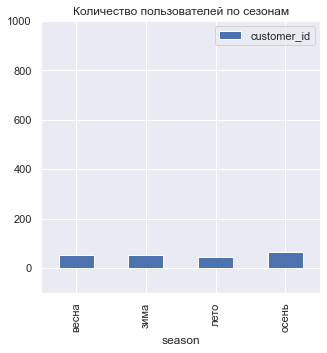

In [143]:
ax = df0.groupby(['season']).agg({'customer_id': 'nunique'}).plot(kind='bar', title = 'Количество пользователей по сезонам', figsize = (5,5))
ax.set_ylim(-100, 1000)
plt.show()

In [144]:
df0_category = df0.pivot_table(index = 'category', aggfunc = {'customer_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
df0_category.sort_values(by='customer_id',ascending=False)

customer_id        price  product_total  quantity
category                                                    
сумки               82  3972.974747       545937.0       144
хозтовары           66  2940.367521      1357372.0       604
растение            35  3694.772727       302511.0       112
интерьер            29  2519.427083       318633.0       183
посуда               5  3029.000000        15145.0         5
техника              1  2849.000000         2849.0         1

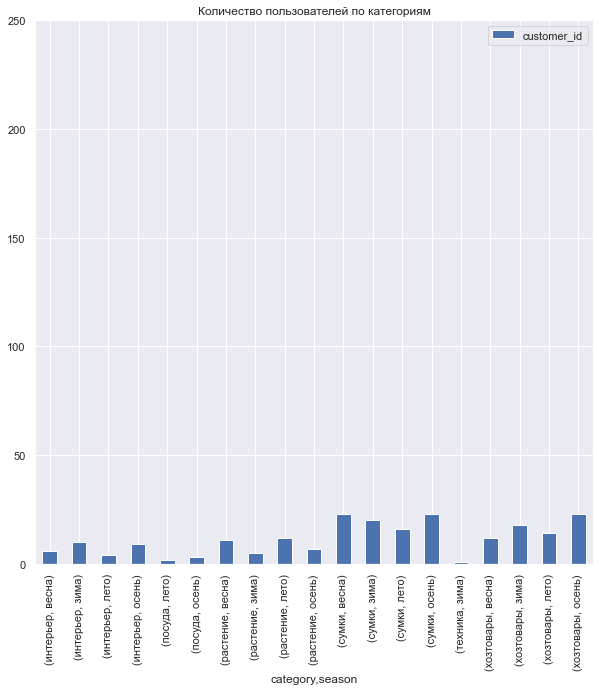

In [145]:
ax = df0.groupby(['category','season']).agg({'customer_id': 'nunique'}).plot(kind='bar', title = 'Количество пользователей по категориям', figsize = (10,10))
ax.set_ylim(0, 250)
plt.show()

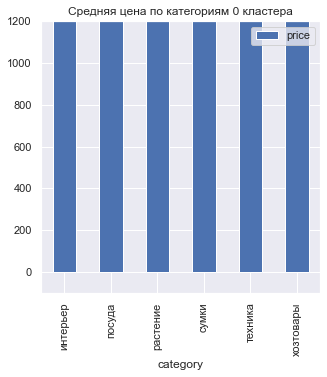

In [146]:
ax = df0.groupby(['category']).agg({'price': 'mean'}).plot(kind='bar', title = 'Средняя цена по категориям 0 кластера', figsize = (5,5))
ax.set_ylim(-100, 1200)
plt.show()

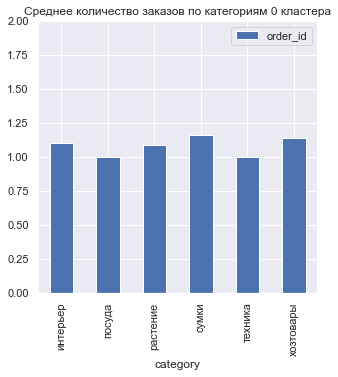

In [147]:
ax = df0.groupby(['category']).agg({'order_id': 'mean'}).plot(kind='bar', title = 'Среднее количество заказов по категориям 0 кластера', figsize = (5,5))
ax.set_ylim(0, 2)
plt.show()

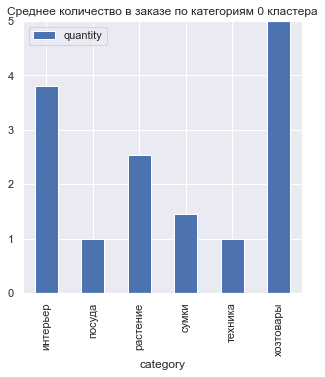

In [148]:
ax = df0.groupby(['category']).agg({'quantity': 'mean'}).plot(kind='bar', title = 'Среднее количество в заказе по категориям 0 кластера', figsize = (5,5))
ax.set_ylim(0,5)
plt.show()

Вывод: Пользователи нулевого кластера чаще всего покупают растения и хозтовары. Спрос у них стабильный по сезонам. Есть небольшое увеличесние зимой и осенью. Средний чек - 564. В целом кластер покупает растения больше всего осенью и меньше летом. Хозтовары лучше всего идут осенью, а вот весной и летом просадка. Покупали по самым высоким цена сумки - 1000 рублей, техника - 830 рублей, интерьер - 750 рублей. Каждую категорию заказывали в среднем 1,1 раза.

In [149]:
cluster_1 = clusters.query('cluster_km == 1')
cluster_1

order_id        price  product_total  \
customer_id                                                                  
004d24e9-4a6c-4d0e-8727-8391dfd4b43a         1   128.000000         1536.0   
018dc738-2846-464d-a421-126a8ed64bc5         1    94.000000          940.0   
01bd5b9a-2b4e-483c-95a3-40b040c392e8         1    52.857143          408.0   
022ecd2e-bc6c-4e78-938e-b9e4bc526271         1   118.857143         1214.0   
036118cf-c198-48fa-ba15-6d841482a56d         2   112.000000         1926.0   
051edfd2-b09e-4e48-b12d-cf6ab2fdcc5f         1    37.000000          555.0   
059d1900-8450-47b0-b914-e5744cea5017         1   111.090909         1222.0   
060d95a3-3771-4aa5-9fdc-34a0b301fff7         1    86.000000          688.0   
07571c24-fd53-4b24-90c9-dae270f4630a         1    37.000000          592.0   
0a29b892-f32e-483a-871c-d05bb91bbb95         1   825.000000         5775.0   
0a76b2a5-b894-4dd8-a7f9-2b5b4f1e674a         1    86.000000         1548.0   
0adba506-249c-40b5-839d-a59d7a275cd7         3    74.000000          370.0   
0ced9736-060c-47f7-b416-7f97a9945713         1   180.400000         1804.0   
0d1b15b6-9cf3-4642-8bc3-74c7dee7b40e         3   140.300000         1538.0   
0e117bc7-82df-474f-a5db-0c50f16701f1         1    51.000000         1275.0   
0f47231c-3a68-404a-88f7-08a4a172c17f         1    53.230769          812.0   
0f7bcaf7-e055-4183-9953-664558dfea70         1    89.000000          712.0   
11e4d71d-0922-4479-b7a0-b27adba50464         1    20.000000          300.0   
1441d772-6f55-490f-8edf-171bef655b16         1   104.500000         1045.0   
14ad8380-48e9-4e0b-b7b7-298111d0448e         1   178.000000         1780.0   
14cc96d3-7d14-4e84-9c15-76e57b642c72         1    20.000000          500.0   
161e1b98-45ba-4b4e-8236-e6e3e70f6f7c         1    82.000000          820.0   
161ec5a3-e6df-4a8c-98ad-089aeac5bcc3         1   172.000000         1892.0   
17213b88-1514-47a4-b8aa-ce51378ab34e         1   593.500000         4748.0   
17ca17e1-9544-48ea-a053-368480d66e6f         1   125.800000         2707.0   
1809d8b0-c702-450d-a73c-76fc90386411         1    93.090909         1434.0   
18128d49-b02e-4bc4-a0af-da96eec807c1         1    22.000000          198.0   
198ef376-5489-4087-bace-47dd562710d2         1   120.000000         1080.0   
19905411-54a7-4752-b660-409111a13c85         1   169.000000         2328.0   
1a0d0ba2-989a-44cf-a0f6-97e2aaa0ebb9         1    20.000000          400.0   
1a725b7e-f09b-4bc1-8579-b9893adb91f8         1    99.111111         1784.0   
1ad78811-b8b9-4607-9e9b-9b105927534e         1   142.823529         2788.0   
1bc8ad38-3392-4042-8cde-aa5de306c947         1    57.411765          976.0   
1f5425f2-1e0b-4568-b2fe-c413238ba243         1   439.000000         4390.0   
20d274bb-da0c-45e7-991a-2822476b117e         1    99.538462         1534.0   
2459fe55-74d9-4e11-b82a-5265594f255e         1   149.066667         2236.0   
278cffb9-4414-449a-8cb8-ffdbef1bf1d8         1    45.833333          363.0   
28195156-9812-4a27-a3e3-a1ebf41b5d64         1    90.000000          900.0   
2878c1b9-220e-4604-8f60-f09bbca1a688         2    96.500000         1327.0   
29655d47-d948-4b42-aeb9-2c10cc8fc09c         1   150.000000         1350.0   
2a1d60f3-cdc4-49db-8f2b-919bb8098411         1   216.600000         2166.0   
2ad90b3d-f3ad-4ae6-8ed7-6f9dd539dc59         1    38.000000          380.0   
2c2b3410-8218-4671-a208-4d20ed55056a         1    71.100000          770.0   
2c56e601-e092-4e20-96f3-0d0abf4d9502         1    78.000000          624.0   
2c8b9386-2e8c-4ee9-8aa4-2b4875b68578         1    59.000000         1127.0   
2efd4944-edbd-4e6e-bf52-205e39dcda5e         1   285.000000         3705.0   
2fedebd2-6de9-4c3a-bab5-48c8e6e8c959         1   125.428571         1036.0   
3414d523-5337-49b9-84f5-dd151a0b5077         2    98.285714          688.0   
35bf6304-20ea-47fd-a5a5-2d74459b2eef         2   128.500000         1799.0   
363f8d24-6d16-428f-8c89-a0fab51a5436         1   542.000000 

In [150]:
cluster_1['product_total'].sum()

433766.0

In [151]:
cluster_1['quantity'].sum()

3388

In [152]:
cluster_1['average_check'].mean()

135.05613748410724

In [153]:
cluster_1['product_total'].value_counts().sum()

251

In [154]:
df_1 = df1.merge(cluster_1, on='customer_id', how='right')
df_1

customer_id season   category  order_id  \
0     004d24e9-4a6c-4d0e-8727-8391dfd4b43a   зима  хозтовары         1   
1     018dc738-2846-464d-a421-126a8ed64bc5   зима     посуда         1   
2     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
3     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
4     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
5     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
6     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
7     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
8     01bd5b9a-2b4e-483c-95a3-40b040c392e8  весна   растение         1   
9     022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
10    022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
11    022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
12    022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
13    022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
14    022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
15    022ecd2e-bc6c-4e78-938e-b9e4bc526271   зима   растение         1   
16    036118cf-c198-48fa-ba15-6d841482a56d   зима   растение         2   
17    036118cf-c198-48fa-ba15-6d841482a56d   зима     посуда         2   
18    036118cf-c198-48fa-ba15-6d841482a56d   зима   растение         2   
19    036118cf-c198-48fa-ba15-6d841482a56d   зима     посуда         2   
20    051edfd2-b09e-4e48-b12d-cf6ab2fdcc5f  весна   растение         1   
21    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
22    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
23    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
24    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
25    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
26    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
27    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
28    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
29    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
30    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
31    059d1900-8450-47b0-b914-e5744cea5017  весна   растение         1   
32    060d95a3-3771-4aa5-9fdc-34a0b301fff7  весна   растение         1   
33    07571c24-fd53-4b24-90c9-dae270f4630a  весна  хозтовары         1   
34    0a29b892-f32e-483a-871c-d05bb91bbb95   зима     посуда         1   
35    0a76b2a5-b894-4dd8-a7f9-2b5b4f1e674a   зима     посуда         1   
36    0a76b2a5-b894-4dd8-a7f9-2b5b4f1e674a   зима     посуда         1   
37    0a76b2a5-b894-4dd8-a7f9-2b5b4f1e674a   зима     посуда         1   
38    0adba506-249c-40b5-839d-a59d7a275cd7  осень   растение         3   
39    0adba506-249c-40b5-839d-a59d7a275cd7  осень   растение         3   
40    0adba506-249c-40b5-839d-a59d7a275cd7  осень   растение         3   
41    0adba506-249c-40b5-839d-a59d7a275cd7  осень   растение         3   
42    0adba506-249c-40b5-839d-a59d7a275cd7  осень   растение         3   
43    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
44    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
45    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
46    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
47    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
48    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
49    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
50    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
51    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
52    0ced9736-060c-47f7-b416-7f97a9945713   лето   растение         1   
53    0d1b15b6-9cf3-4642-8bc3-74c7d

In [155]:
df_1_season = df_1.pivot_table(index = 'season', aggfunc = {'customer_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
df_1_season.sort_values(by='customer_id',ascending=False)

customer_id       price  product_total  quantity
season                                                  
весна           103  121.474690      1087363.0      9510
осень            65  222.122889      1064529.0      4778
зима             52  157.587217       400045.0      2881
лето             39  125.021790       265176.0      2154

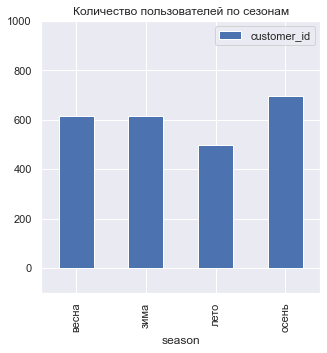

In [156]:
ax = df1.groupby(['season']).agg({'customer_id': 'nunique'}).plot(kind='bar', title = 'Количество пользователей по сезонам', figsize = (5,5))
ax.set_ylim(-100, 1000)
plt.show()

In [157]:
df_1_category = df_1.pivot_table(index = 'category', aggfunc = {'customer_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
df_1_category.sort_values(by='customer_id',ascending=False)

customer_id        price  product_total  quantity
category                                                    
растение           175   135.429540      2070204.0     16024
хозтовары           45   290.602979       403132.0      1408
интерьер            29    95.263983        99284.0      1212
посуда              27   225.418722       102428.0       531
сумки                5   758.746753        76926.0        94
техника              1  1206.277778        65139.0        54

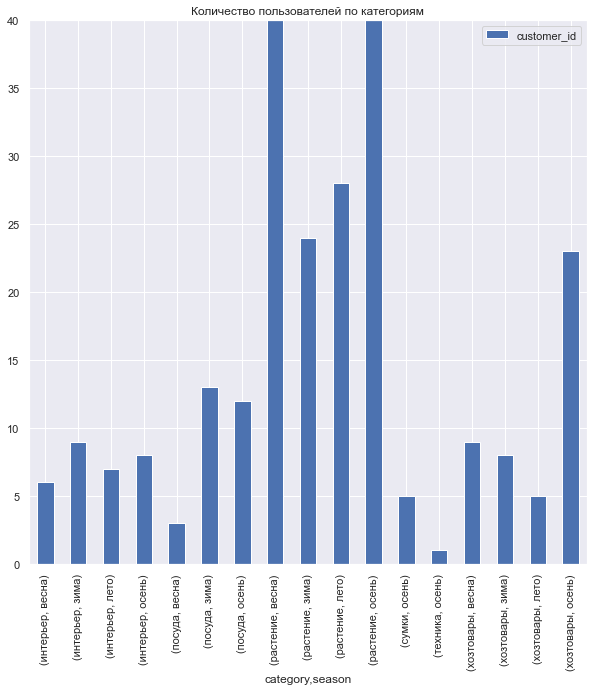

In [158]:
ax = df_1.groupby(['category','season']).agg({'customer_id': 'nunique'}).plot(kind='bar', title = 'Количество пользователей по категориям', figsize = (10,10))
ax.set_ylim(0, 40)
plt.show()

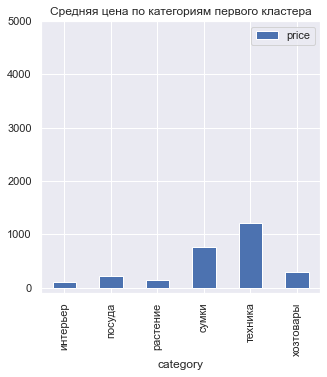

In [159]:
ax = df_1.groupby(['category']).agg({'price': 'mean'}).plot(kind='bar', title = 'Средняя цена по категориям первого кластера', figsize = (5,5))
ax.set_ylim(-100, 5000)
plt.show()

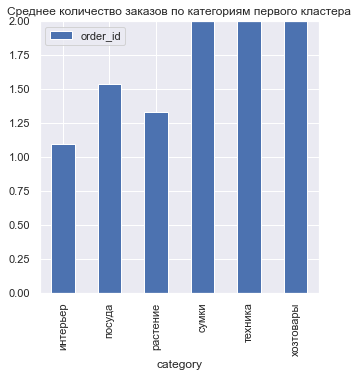

In [160]:
ax = df_1.groupby(['category']).agg({'order_id': 'mean'}).plot(kind='bar', title = 'Среднее количество заказов по категориям первого кластера', figsize = (5,5))
ax.set_ylim(0, 2)
plt.show()

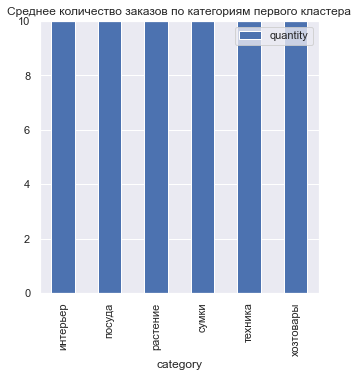

In [161]:
ax = df_1.groupby(['category']).agg({'quantity': 'mean'}).plot(kind='bar', title = 'Среднее количество заказов по категориям первого кластера', figsize = (5,5))
ax.set_ylim(0, 10)
plt.show()

Вывод: Пользователи первого кластера покупают сумки и хозтовары. Видна просадка активности летом. Средний чек 3757. Видно, что спрос осентю на сумки и хоз.товары примерно равен. ПОкупали по высокой цене сумки - 4000 и растения - 3800. Среднее количество заказов по категориям - 1,1.

In [162]:
cluster_2 = clusters.query('cluster_km == 2')
cluster_2

order_id        price  product_total  \
customer_id                                                                  
000d6849-084e-4d9f-ac03-37174eaf60c4         1   138.750000          555.0   
001cee7f-0b29-4716-b202-0042213ab038         1   442.000000          442.0   
00299f34-5385-4d13-9aea-c80b81658e1b         1   457.000000          914.0   
002d4d3a-4a59-406b-86ec-c3314357e498         1  1649.000000         1649.0   
003bbd39-0000-41ff-b7f9-2ddaec152037         1  1162.000000         2324.0   
005ba170-45e8-42de-93f7-192481ae2659         1  1199.000000         1199.0   
00bd74b1-2792-47db-a2f1-680a09ac5026         1   937.000000          937.0   
00c0f92a-121a-4883-a78d-2c7b5fe187de         1   134.000000          134.0   
00cd704a-a65c-4865-b39a-779f1b4f1d1a         1   112.000000          112.0   
00e59a12-06d5-47fc-9a33-bfc53aca1e9f         1   899.000000         1798.0   
00ff5327-0fba-481c-8a07-47a95093a213         1  1049.000000         1049.0   
0114e87e-78e2-49bf-9c8c-bbddd7191a3f         1   974.000000          974.0   
0131d2f9-e553-4cb6-ac85-f96e9cb7cb47         1  1574.000000         1574.0   
01626eda-0717-4a39-826e-1982a358576d         1   599.000000          599.0   
01ca3206-da26-470d-8240-f34e7086c214         1   157.000000          157.0   
01f95d43-4a8d-45e5-9c23-cccd211e6d30         1    44.000000           44.0   
02477bed-bad4-482f-9e47-80d7f6d77c7b         1   524.000000          524.0   
02648fcc-ab94-4f94-ad3b-fbaef270d001         1  1912.000000         1912.0   
0279a2cc-6bd4-4004-bc6c-cf43ec9bdeee         1   157.000000          157.0   
02a27adc-a1fe-4aaf-9945-1ab779979537         1    45.000000           45.0   
02cb74c5-348f-43dc-ba4d-e546a21a07f1         1   134.000000          134.0   
030c91b7-311d-407e-a3ac-e64c03537569         1   150.000000          150.0   
03134fa3-9ce0-4973-849d-32c21e26d64e         1  1177.000000         1177.0   
03427797-398e-497d-a303-48879e7ba7f7         1   525.000000          525.0   
034ed71f-ad8c-4891-848b-297a64c9ec22         1   329.000000          658.0   
036edc2c-d0ad-4c71-99f6-226db1b883f4         1   239.000000         1195.0   
03865a43-8c19-4d4e-ab51-7ec516614a83         1   135.000000          540.0   
03b7b4a5-9e2c-42f9-a131-96f3d2772f17         1  1574.000000         1574.0   
03d875f5-1100-45be-9979-6269a8573c00         1  1049.000000         1049.0   
04416514-5346-4f90-93e3-fb7365e2ee8c         1    30.000000           30.0   
04c9031f-1248-4fd9-add0-6c5a4efaa58e         1   599.000000          599.0   
04d4b824-7b31-4262-8aa0-e43772602521         1   734.000000          734.0   
04f4acb1-8c6d-4e1c-a960-3fa400d220a7         1  1874.000000         1874.0   
051d78d4-3667-4018-90d5-2e7ae8c98816         1   727.000000          727.0   
052616d4-286c-4ae0-87ec-6d7f1c41f56f         1   712.000000         1424.0   
052b23ea-1a8c-4498-b52f-9c4a94a510cd         1  1424.000000         1424.0   
05304729-78e7-4168-b6be-b58423913247         1   614.000000          614.0   
055119fa-4ffb-4780-a696-3cf6808daadf         1   427.000000          427.0   
058f7f22-4359-43c0-9931-98e2f390524a         1   554.000000          554.0   
05c2f18a-6c9d-4fe1-a18b-b575c9f3e1d5         1   420.000000          420.0   
05c8c33d-37de-4ea6-b6c0-97d7622d0f7e         1   749.000000          749.0   
05f74c6f-2395-45ac-a826-9e070652de3e         1  1199.000000         2398.0   
06033df9-559a-42f8-ba07-5cb58fd882c6         1   135.000000          675.0   
0655a313-acda-44ee-87dc-5477b47742e6         1    22.000000           44.0   
0673033d-8bb9-4d9f-afc9-21f0276a5940         1   209.000000          209.0   
067ced0d-1e05-408e-b659-b11d41312f5e         1  1087.000000         1087.0   
068d0b82-44d7-4972-9696-1f9c84983512         1   442.000000          442.0   
06f64a2f-e4bb-452b-93dc-dfc64cc8db43         1   224.000000          224.0   
0735b352-3ce6-4452-8661-f895833320bc         1   374.000000          374.0   
0758367d-cf0e-4e20-b64d-8aaa643f42df         1    52.000000 

In [163]:
cluster_2['product_total'].sum()

1436680.0

In [164]:
cluster_2['quantity'].sum()

3273

In [165]:
cluster_2['average_check'].mean()

561.2255674232309

In [166]:
cluster_2['product_total'].value_counts().sum()

1819

In [167]:
df_2 = df1.merge(cluster_2, on='customer_id', how='right')
df_2

customer_id season   category  order_id  \
0     000d6849-084e-4d9f-ac03-37174eaf60c4  осень   растение         1   
1     000d6849-084e-4d9f-ac03-37174eaf60c4  осень   растение         1   
2     000d6849-084e-4d9f-ac03-37174eaf60c4  осень   растение         1   
3     000d6849-084e-4d9f-ac03-37174eaf60c4  осень   растение         1   
4     001cee7f-0b29-4716-b202-0042213ab038   зима   растение         1   
5     00299f34-5385-4d13-9aea-c80b81658e1b  осень   интерьер         1   
6     002d4d3a-4a59-406b-86ec-c3314357e498   зима      сумки         1   
7     003bbd39-0000-41ff-b7f9-2ddaec152037  осень   интерьер         1   
8     005ba170-45e8-42de-93f7-192481ae2659  осень   интерьер         1   
9     00bd74b1-2792-47db-a2f1-680a09ac5026  осень  хозтовары         1   
10    00c0f92a-121a-4883-a78d-2c7b5fe187de   зима   растение         1   
11    00cd704a-a65c-4865-b39a-779f1b4f1d1a   зима   растение         1   
12    00e59a12-06d5-47fc-9a33-bfc53aca1e9f   лето   интерьер         1   
13    00ff5327-0fba-481c-8a07-47a95093a213  весна   растение         1   
14    0114e87e-78e2-49bf-9c8c-bbddd7191a3f  осень  хозтовары         1   
15    0131d2f9-e553-4cb6-ac85-f96e9cb7cb47   лето   растение         1   
16    01626eda-0717-4a39-826e-1982a358576d  осень   растение         1   
17    01ca3206-da26-470d-8240-f34e7086c214   зима   растение         1   
18    01f95d43-4a8d-45e5-9c23-cccd211e6d30  весна   растение         1   
19    02477bed-bad4-482f-9e47-80d7f6d77c7b  осень   растение         1   
20    02648fcc-ab94-4f94-ad3b-fbaef270d001   зима   растение         1   
21    0279a2cc-6bd4-4004-bc6c-cf43ec9bdeee   лето   растение         1   
22    02a27adc-a1fe-4aaf-9945-1ab779979537   лето  хозтовары         1   
23    02cb74c5-348f-43dc-ba4d-e546a21a07f1  весна   растение         1   
24    030c91b7-311d-407e-a3ac-e64c03537569   лето      сумки         1   
25    03134fa3-9ce0-4973-849d-32c21e26d64e  весна   растение         1   
26    03427797-398e-497d-a303-48879e7ba7f7   лето      сумки         1   
27    034ed71f-ad8c-4891-848b-297a64c9ec22  осень  хозтовары         1   
28    036edc2c-d0ad-4c71-99f6-226db1b883f4   зима   растение         1   
29    036edc2c-d0ad-4c71-99f6-226db1b883f4   зима   растение         1   
30    036edc2c-d0ad-4c71-99f6-226db1b883f4  весна   растение         1   
31    03865a43-8c19-4d4e-ab51-7ec516614a83   лето   растение         1   
32    03865a43-8c19-4d4e-ab51-7ec516614a83   лето   растение         1   
33    03865a43-8c19-4d4e-ab51-7ec516614a83   лето   растение         1   
34    03865a43-8c19-4d4e-ab51-7ec516614a83   лето   растение         1   
35    03b7b4a5-9e2c-42f9-a131-96f3d2772f17  осень  хозтовары         1   
36    03d875f5-1100-45be-9979-6269a8573c00  осень      сумки         1   
37    04416514-5346-4f90-93e3-fb7365e2ee8c  осень  хозтовары         1   
38    04c9031f-1248-4fd9-add0-6c5a4efaa58e   лето   растение         1   
39    04d4b824-7b31-4262-8aa0-e43772602521  осень   растение         1   
40    04f4acb1-8c6d-4e1c-a960-3fa400d220a7   зима   интерьер         1   
41    051d78d4-3667-4018-90d5-2e7ae8c98816   зима      сумки         1   
42    052616d4-286c-4ae0-87ec-6d7f1c41f56f   зима  хозтовары         1   
43    052b23ea-1a8c-4498-b52f-9c4a94a510cd   зима   растение         1   
44    05304729-78e7-4168-b6be-b58423913247  весна   растение         1   
45    055119fa-4ffb-4780-a696-3cf6808daadf  осень   растение         1   
46    058f7f22-4359-43c0-9931-98e2f390524a   лето   растение         1   
47    05c2f18a-6c9d-4fe1-a18b-b575c9f3e1d5   лето   растение         1   
48    05c8c33d-37de-4ea6-b6c0-97d7622d0f7e  осень   растение         1   
49    05f74c6f-2395-45ac-a826-9e070652de3e  осень   интерьер         1   
50    05f74c6f-2395-45ac-a826-9e070652de3e  осень   интерьер         1   
51    06033df9-559a-42f8-ba07-5cb58fd882c6  осень   растение         1   
52    06033df9-559a-42f8-ba07-5cb58fd882c6  осень   растение         1   
53    06033df9-559a-42f8-ba07-5cb58

In [168]:
df_2_season = df_2.pivot_table(index = 'season', aggfunc = {'customer_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
df_2_season.sort_values(by='customer_id',ascending=False)

customer_id       price  product_total  quantity
season                                                  
осень           532  523.182146       752514.0      1976
зима            491  582.092358       559456.0      1125
весна           412  412.098800       499426.0      1774
лето            394  491.850294       414863.0      1146

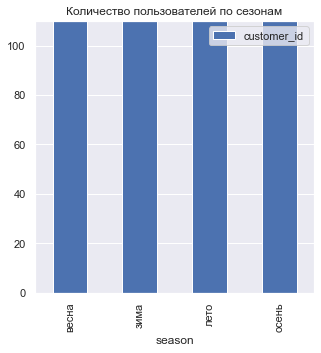

In [169]:
ax = df_2.groupby(['season']).agg({'customer_id': 'nunique'}).plot(kind='bar', title = 'Количество пользователей по сезонам', figsize = (5,5))
ax.set_ylim(0, 110)
plt.show()

In [170]:
df_2_category = df_2.pivot_table(index = 'category', aggfunc = {'customer_id':'nunique','quantity': 'sum', 'product_total': 'sum','price':'mean'})
df_2_category.sort_values(by='customer_id',ascending=False)

customer_id        price  product_total  quantity
category                                                    
растение           858   336.629373       899085.0      3666
хозтовары          410   611.401080       489873.0       964
интерьер           230   723.673891       287753.0       527
сумки              202  1007.794350       370014.0       368
посуда             149   377.448790       142932.0       448
техника             25   870.695238        36602.0        48

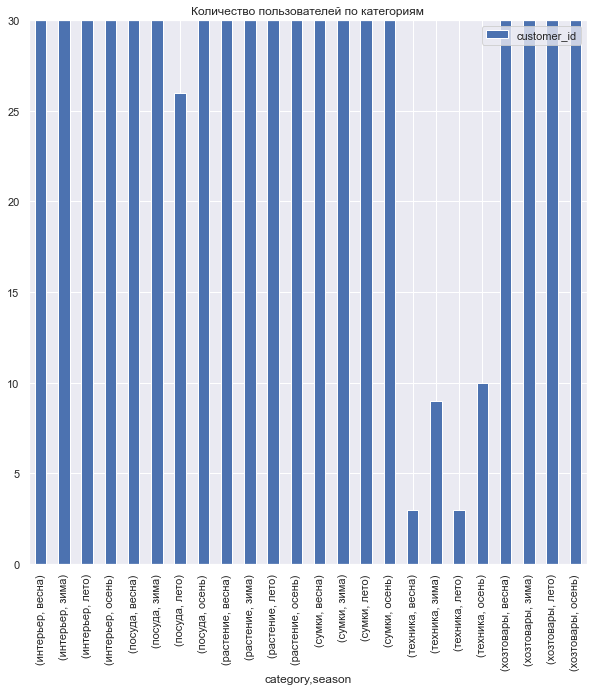

In [171]:
ax = df_2.groupby(['category','season']).agg({'customer_id': 'nunique'}).plot(kind='bar', title = 'Количество пользователей по категориям', figsize = (10,10))
ax.set_ylim(0, 30)
plt.show()

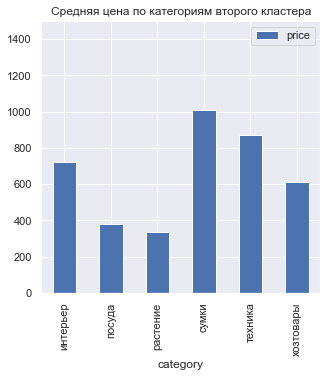

In [172]:
ax = df_2.groupby(['category']).agg({'price': 'mean'}).plot(kind='bar', title = 'Средняя цена по категориям второго кластера', figsize = (5,5))
ax.set_ylim(0, 1500)
plt.show()

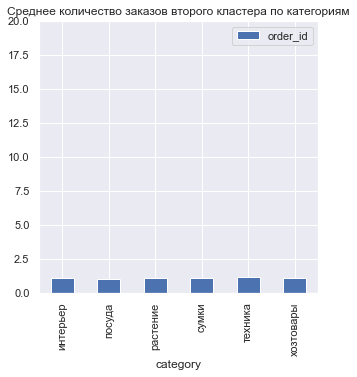

In [173]:
ax = df_2.groupby(['category']).agg({'order_id': 'mean'}).plot(kind='bar', title = 'Среднее количество заказов второго кластера по категориям', figsize = (5,5))
ax.set_ylim(0, 20)
plt.show()

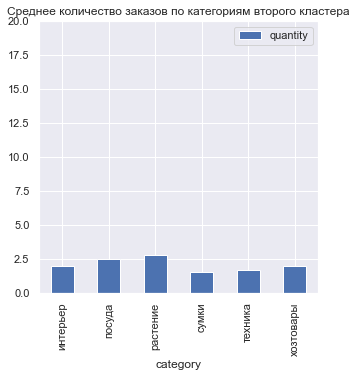

In [174]:
ax = df_2.groupby(['category']).agg({'quantity': 'mean'}).plot(kind='bar', title = 'Среднее количество заказов по категориям второго кластера', figsize = (5,5))
ax.set_ylim(0, 20)
plt.show()

Вывод: Пользователи 2 кластера покупают растения весной. Остальные категории и сезоны в явной просадке.
Покупали по высокой цене технику - 1200 рублей и сумки - 780 рублей. Было много заказов по технике - 17.

# Общий вывод: 

* Во всех категориях наблюдается сезонность продаж;
* Больше всего приносит денег категория растения. Меньше всего - электроника
* Большинство покупок совершается в обед; 
* Продажи в 2019 году упали относительно показателей 2018 года; 

Выделил три кластера. 

* Вывод: Пользователи нулевого кластера чаще всего покупают растения и хозтовары. Спрос у них стабильный по сезонам. Есть небольшое увеличесние зимой и осенью. Средний чек - 564. В целом кластер покупает растения больше всего осенью и меньше летом. Хозтовары лучше всего идут осенью, а вот весной и летом просадка. Покупали по самым высоким цена сумки - 1000 рублей, техника - 830 рублей, интерьер - 750 рублей. Каждую категорию заказывали в среднем 1,1 раза. Покупают немного. Макимальный показатель растения - 3 штуки в среднем в одном заказе.
* Пользователи первого кластера покупают сумки и хозтовары. Видна просадка активности летом. Средний чек 3757. Видно, что спрос осентю на сумки и хоз.товары примерно равен. Покупали по высокой цене сумки - 4000 и растения - 3800. Среднее количество заказов по категориям - 1,1. В среднем в заказе немного позиций. Максимальный показатель - хозтовары 5 штук. 
*  Пользователи 2 кластера покупают растения весной. Остальные категории и сезоны в явной просадке.
Покупали по высокой цене технику - 1200 рублей и сумки - 780 рублей. Было много заказов по технике - 17. Заказывают много техники - 17,6 единиц в заказе в среднем. 


Увеличить возвращаемость пользователей можно расылкой рекомендаций на основе их покупок (как описано выше). 

Так же можно в рассылки включать сопутсвующие товары: например к растениям хоз.товары, куда входят тележки и все что может пригодиться в саду.


